In [86]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from keras.utils import plot_model

import xgboost as xgb

import shap
import lime

from PIL import Image

from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option("display.max_columns", 500)

## Grangers Causality Matrix Creation Method

In [2]:
maxlag=12

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables_y = None, variables_x = None, test = 'ssr_chi2test', verbose=False):
        
    if (variables_y != None) & (variables_x == None):
        variables_x = data.columns
        
    elif (variables_y == None) & (variables_x != None):
        variables_y = data.columns
        
    else:
        variables_y = data.columns
        variables_x = data.columns       
        
    dataset = pd.DataFrame(np.zeros((len(variables_y), len(variables_x))), columns=variables_x, index=variables_y)
        
    length = len(variables_x)   
    count = 0    
    for c in variables_x:
        for r in variables_y:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
        # Update user on progress
        count = count + 1
        print(f'Completed: {c}; {round(count / length * 100, 2)}% complete.')

    dataset.columns = [var + '_x' for var in variables_x]

    dataset.index = [var + '_y' for var in variables_y]

    return dataset

#grangers_causality_matrix(dataset, variables = dataset.columns) 

## Loading Stock & CSI Data

In [3]:
# Import data files
df_data = pd.read_csv('stock_data.csv')
csi_data = pd.read_csv('csi_data.csv')

print("Stock Dataset Size : ",df_data.shape)
print("CSI Dataset Size : ",csi_data.shape)
# Convert date column to datetime format
df_data['date'] = df_data.apply(lambda x: pd.to_datetime(x['date']), axis = 1)
csi_data['date'] = csi_data.apply(lambda x: pd.to_datetime(x['date']), axis = 1)

# Set date column as index
df_data.set_index('date', inplace = True)
csi_data.set_index('date', inplace = True)

# Create list of all S&P500 tickers to help reduce total data size

df_data.head()

Stock Dataset Size :  (3523, 1975)
CSI Dataset Size :  (3523, 4)


,A,AA,AAL,AAN,AAOI,AAP,AAPL,AAWW,AAXJ,AAXN,ABB,ABBV,ABC,ABG,ABMD,ABT,ACAD,ACB,ACH,ACIA,ACN,ACWI,ACWV,ADBE,ADI,ADM,ADNT,ADP,ADS,ADSK,ADTN,ADUS,ADVM,AEE,AEM,AEO,AEP,AER,AES,AFG,AFL,AFTY,AG,AGCO,AGG,AGM,AGN,AGNC,AGO,AGQ,AIG,AIMC,AINV,AIZ,AJG,AKAM,AKRX,AKS,ALB,ALFA,ALG,ALGN,ALGT,ALK,ALKS,ALL,ALLE,ALLK,ALLY,ALNY,ALV,ALXN,AMAG,AMAT,AMBA,AMC,AMD,AME,AMED,AMG,AMGN,AMJ,AMKR,AMLP,AMN,AMP,AMRN,AMSC,AMT,AMTD,AMWD,AMX,AMZN,AN,ANAB,ANAT,ANET,ANF,ANIK,ANIP,ANSS,ANTM,AOBC,AON,APA,APD,APH,APHA,APO,APPF,APRN,APTV,AR,ARCC,ARCH,ARE,ARGX,ARKW,ARLP,ARMK,ARNA,ARQL,ARW,ARWR,ASH,ASHR,ASHS,ASML,ASNA,ASND,ATGE,ATHM,ATO,ATR,ATUS,ATVI,AU,AUPH,AUY,AVAV,AVB,AVGO,AVLR,AVP,AVT,AVTR,AVY,AVYA,AWI,AWK,AWR,AXE,AXGT,AXL,AXP,AXS,AXSM,AXTA,AYI,AYX,AZN,AZO,AZPN,BA,BABA,BAC,BAH,BANC,BAND,BAP,BAX,BB,BBBY,BBD,BBH,BBY,BC,BCC,BCO,BCPC,BCS,BDX,BE,BERY,BFAM,BG,BGNE,BGS,BHC,BHF,BHP,BHVN,BIB,BIDU,BIG,BIIB,BIL,BILI,BIO,BIS,BITA,BJK,BJRI,BK,BKD,BKF,BKH,BKLN,BKNG,BKR,BKX,BLCN,BLD,BLDR,BLK,BLKB,BLL,BLOK,BLUE,BLV,BMA,BMO,BMRN,BMY,BND,BNO,BOIL,BOKF,BOLD,BOOM,BOTZ,BOX,BP,BPMC,BPOP,BPY,BR,BRF,BRKS,BRZU,BSV,BSX,BTU,BUD,BURL,BVN,BWA,BWX,BX,BXP,...,TWTR,TX,TXG,TXN,TXT,TYD,TYL,TZA,UA,UAA,UAL,UBER,UBIO,UBT,UCO,UCOM,UDN,UDOW,UGA,UGL,UHS,UHT,UI,UIS,UL,ULE,ULTA,UMBF,UMDD,UN,UNG,UNH,UNIT,UNP,UPLD,UPRO,UPS,URA,URBN,URE,URI,URTH,URTY,USB,USCR,USD,USL,USMV,USNA,USO,USPH,UTHR,UTX,UTY,UUP,UVXY,UWM,UYG,UYM,V,VAC,VAL,VALE,VAR,VAW,VB,VBK,VBR,VC,VCR,VDC,VDE,VEA,VECO,VEEV,VER,VFC,VFH,VG,VGK,VHC,VHT,VIAC,VIAV,VIG,VIIX,VIPS,VIS,VIX,VIXM,VIXY,VKTX,VLO,VLY,VMC,VMI,VMW,VNDA,VNET,VNOM,VNQ,VO,VOD,VOE,VONV,VOT,VOX,VOYA,VPL,VPU,VRAY,VRNS,VRSK,VRSN,VRTX,VSAT,VSLR,VST,VT,VTR,VTV,VUG,VV,VWO,VXF,VXUS,VXX,VXZ,VYM,VZ,W,WAB,WAT,WB,WBA,WBC,WCN,WDAY,WDC,WDFC,WEC,WELL,WEN,WES,WETF,WEX,WFC,WGO,WH,WHR,WIFI,WING,WIRE,WIX,WLK,WLL,WLTW,WM,WMB,WMGI,WMT,WORK,WPC,WPM,WPP,WPX,WRB,WRK,WSM,WSO,WST,WU,WUBA,WVE,WW,WWD,WWE,WY,WYND,WYNN,X,XAU,XBI,XDC,XEC,XEL,XEO,XES,XHB,XHE,XLB,XLC,XLE,XLF,XLI,XLK,XLNX,XLP,XLRE,XLU,XLV,XLY,XME,XOM,XOP,XPER,XPO,XPP,XRAY,XRT,XRX,XSD,XSP,XYL,Y,YANG,YCS,YELP,YETI,YEXT,YINN,YNDX,YOLO,YPF,YRCW,YUM,YUMC,YY,Z,ZAGG,ZAYO,ZBH,ZBIO,ZBRA,ZEN,ZG,ZGNX,ZION,ZIOP,ZM,ZNGA,ZROZ,ZS,ZSL,ZTO,ZTS,ZUO,ZYME,csi1,csi_difference
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.189130,0.567085,0.295580,0.103657,NaN,0.343489,0.084282,0.351223,NaN,0.055722,0.080426,NaN,0.166772,0.128887,0.073796,0.149772,0.078848,NaN,0.156669,NaN,0.231255,NaN,NaN,0.304025,0.289661,0.192423,NaN,0.289997,0.291713,0.337411,0.230229,NaN,NaN,0.409313,0.173954,0.122652,0.294870,NaN,0.127861,0.201368,0.183781,NaN,NaN,0.131965,0.794317,0.239148,0.259984,NaN,0.199684,NaN,10.989740,NaN,0.429282,0.347830,0.247356,0.164167,0.034491,0.064009,0.161681,NaN,0.164483,0.049566,NaN,0.069554,0.161957,0.431965,NaN,NaN,NaN,0.102289,0.270272,0.040036,0.088635,0.144672,NaN,NaN,0.255722,0.099436,0.247376,0.650592,0.634254,NaN,0.043883,NaN,0.155012,0.332281,0.106551,0.666141,0.215470,0.193765,0.194949,0.122928,0.375533,0.173639,NaN,0.908445,NaN,0.518706,0.091081,0.997317,0.156235,0.626362,0.031650,0.294002,0.559590,0.435228,0.087747,NaN,NaN,NaN,NaN,NaN,NaN,0.128256,NaN,0.650039,NaN,NaN,0.149526,NaN,1.219416,0.049329,0.257143,0.318863,0.231374,NaN,NaN,0.181581,1.582873,NaN,0.153512,NaN,0.211050,0.207182,NaN,0.055012,0.413181,NaN,0.056433,NaN,0.721705,NaN,NaN,0.223283,0.189345,NaN,0.444594,NaN,NaN,NaN,0.125493,0.318548,NaN,0.146882,0.414996,0.248382,NaN,NaN,0.251697,NaN,0.198500,0.732123,0.063931,0.555959,NaN,0.371586,NaN,0.217443,NaN,0.184213,0.164455,0.175243,0.287293,0.050602,0.537990,0.353039,0.322178,NaN,0.381

In [4]:
csi_data.tail()

,csi1,csi2,difference
date,,,
2019-12-24,1.437937,1.220292,0.217645
2019-12-26,1.614389,1.373594,0.240795
2019-12-27,1.725802,1.477884,0.247918
2019-12-30,1.794191,1.562093,0.232099
2019-12-31,1.858108,1.646110,0.211998


### Plotting CSI1 and CSI2 Time-Series

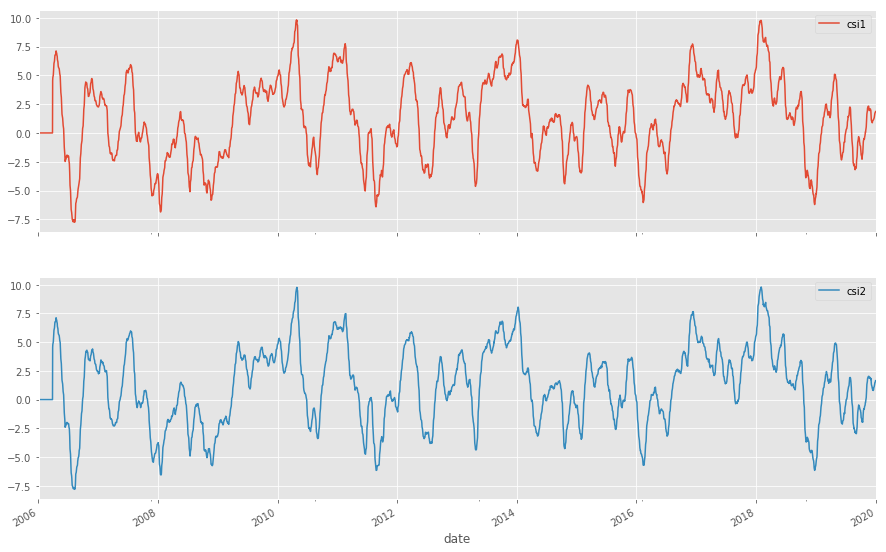

In [5]:
with plt.style.context(("ggplot")):
    csi_data.plot(y=["csi1", "csi2"], figsize=(15,10), subplots=True)

In [6]:
# # Pick 15 random tickers to complete a small test

# import random

# df_new = pd.DataFrame(index = df_subset.index)
# pool = df_subset.columns 

# for i in range(0, 15, 1):    
#     choice = random.choice(pool)    
#     df_new[choice] = df_subset[choice]
    
# df_new['csi1'] = df_subset['csi1']
# df_new['csi_difference'] = df_subset['csi_difference']

## Decomposing Time-Series 

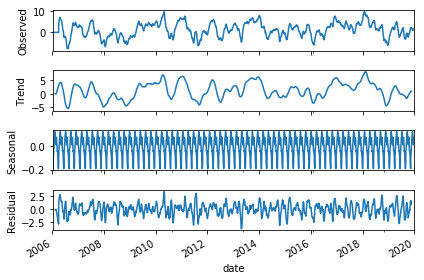

In [7]:
decompose_result = seasonal_decompose(csi_data.csi1, model="additive", freq=52)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

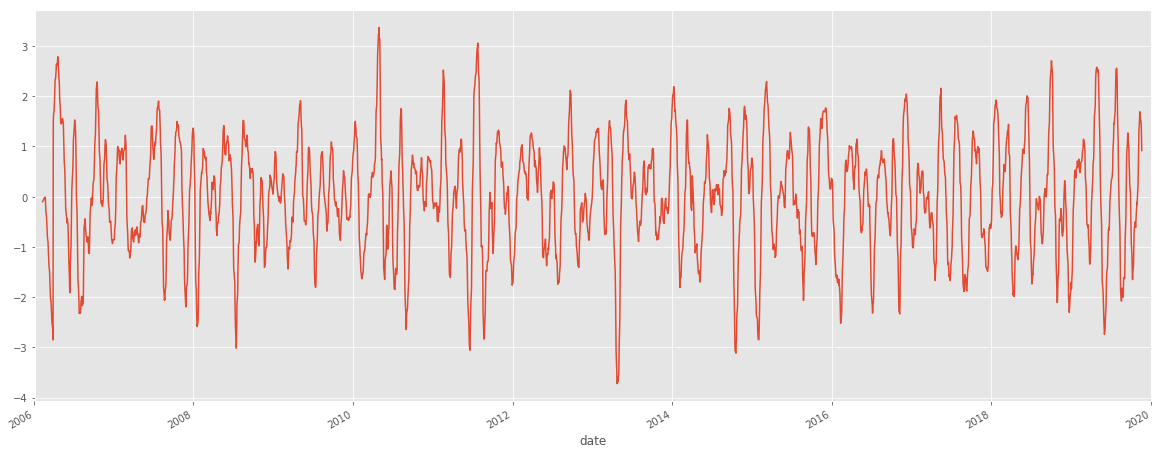

In [8]:
with plt.style.context(("ggplot")):
    residual.plot(figsize=(20,8));

## Statistical Tests to Check Distribution 

In [9]:
stat,p = stats.normaltest(csi_data.csi1)
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('CSI1 : Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('CSI1 : Data looks non-Gaussian (reject null hypothesis)')

Statistics = 63.913, p=0.000
CSI1 : Data looks non-Gaussian (reject null hypothesis)


In [10]:
stat,p = stats.normaltest(csi_data.csi2)
print("Statistics = %.3f, p=%.3f" % (stat,p))
if p> alpha:
    print('CSI2 : Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('CSI2 : Data looks non-Gaussian (reject null hypothesis)')

Statistics = 64.194, p=0.000
CSI2 : Data looks non-Gaussian (reject null hypothesis)


In [11]:
print("Kurtosis of normal distribution (CSI1) : ", stats.kurtosis(csi_data.csi1))
print("Kurtosis of normal distribution (CSI2) : ", stats.kurtosis(csi_data.csi2))

Kurtosis of normal distribution (CSI1) :  -0.473222631779874
Kurtosis of normal distribution (CSI2) :  -0.47594590627204125


Kurtosis test results values near to 0 indicates normal distribution.

In [12]:
print("Skewness of normal distribution (CSI1) : ", stats.kurtosis(csi_data.csi1))
print("Skewness of normal distribution (CSI2) : ", stats.skew(csi_data.csi2))

Skewness of normal distribution (CSI1) :  -0.473222631779874
Skewness of normal distribution (CSI2) :  -0.10136310685550566


#### CSI1

count    3523.000000
mean        1.229909
std         3.357615
min        -7.756103
25%        -1.129128
50%         1.317779
75%         3.666903
max         9.809280
Name: csi1, dtype: float64

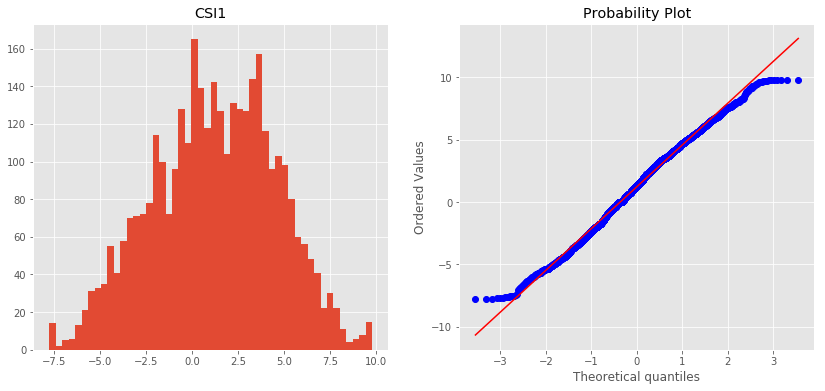

In [13]:
with plt.style.context(("ggplot")):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    csi_data['csi1'].hist(bins=50)
    plt.title('CSI1')
    plt.subplot(1,2,2)
    stats.probplot(csi_data['csi1'], plot=plt);

csi_data.csi1.describe().T

#### CSI2

count    3523.000000
mean        1.201384
std         3.341931
min        -7.814654
25%        -1.164718
50%         1.285738
75%         3.624636
max         9.799463
Name: csi2, dtype: float64

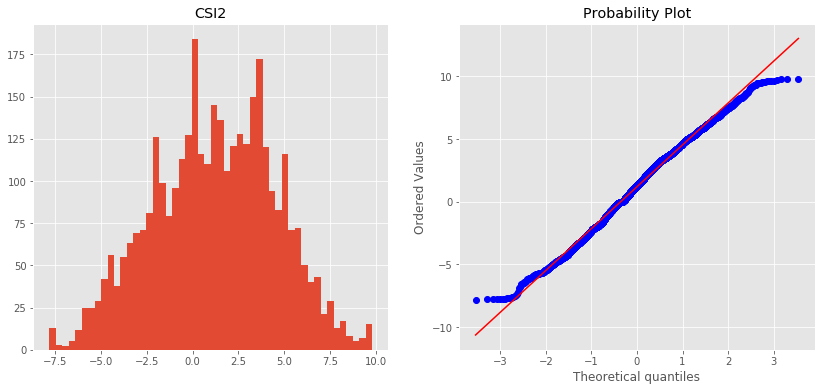

In [14]:
with plt.style.context(("ggplot")):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    csi_data['csi2'].hist(bins=50)
    plt.title('CSI2')
    plt.subplot(1,2,2)
    stats.probplot(csi_data['csi2'], plot=plt);

csi_data.csi2.describe().T

## ACF & PACF

### CSI1

#### ACF

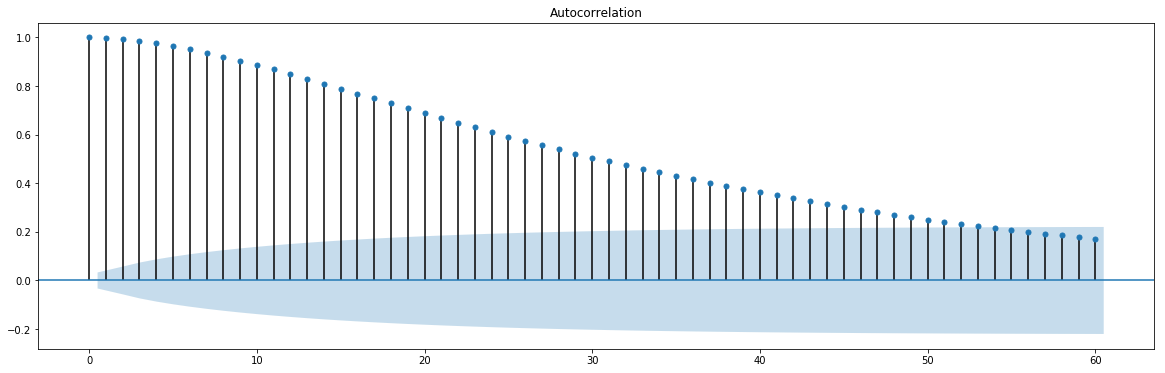

In [15]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plot_acf(csi_data.csi1, lags=60, ax=ax);

#### PACF

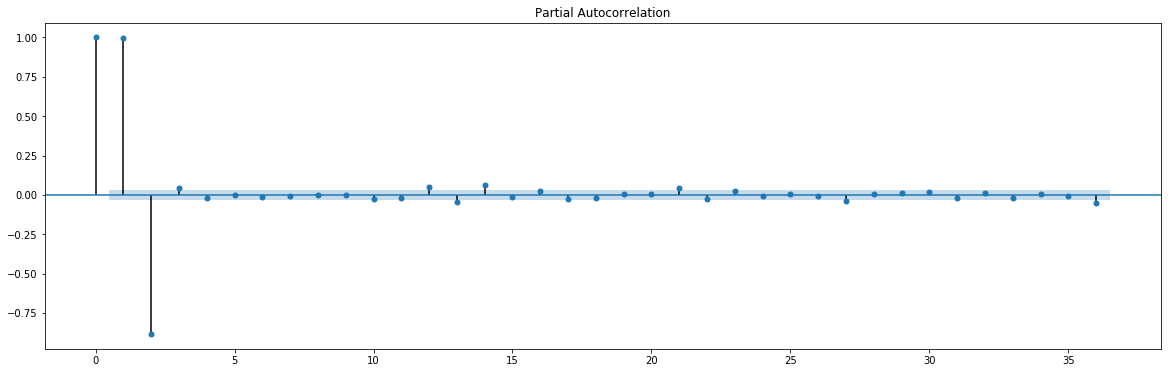

In [16]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plot_pacf(csi_data.csi1, ax=ax);

### CSI1

#### ACF

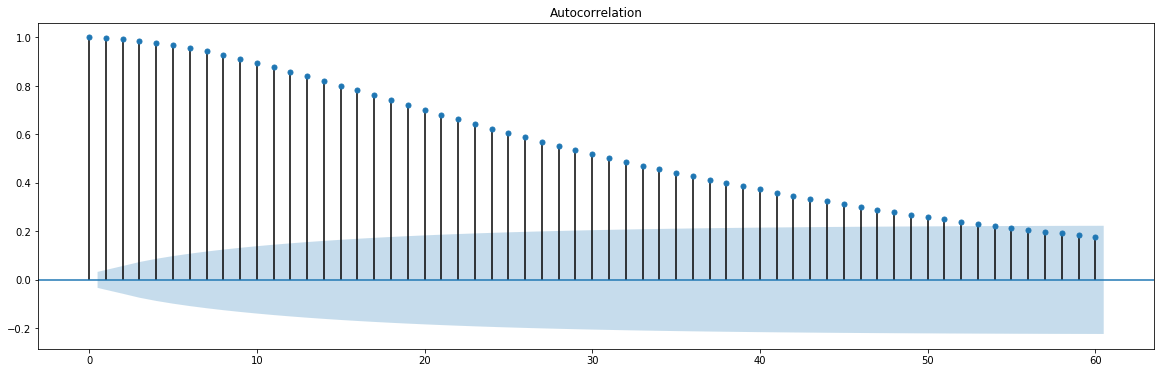

In [17]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plot_acf(csi_data.csi2, lags=60, ax=ax);

#### PACF

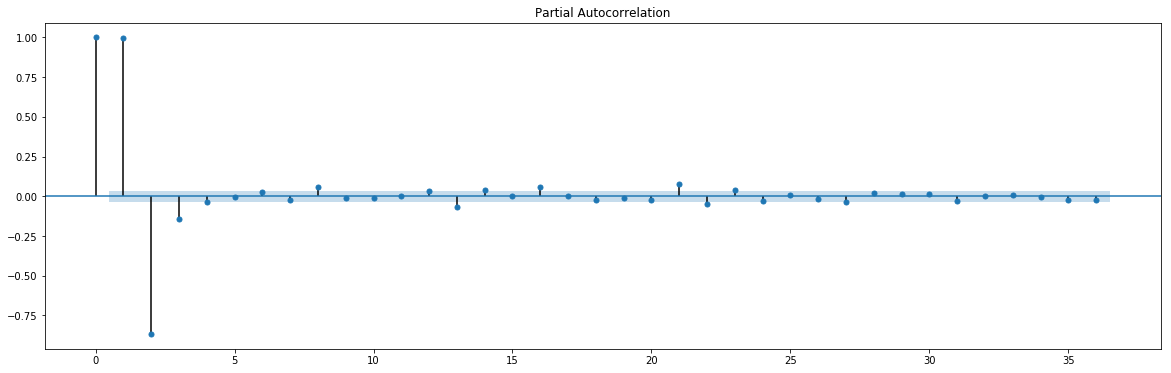

In [18]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plot_pacf(csi_data.csi2, ax=ax);

## Dataset Creation For Machine Learning

In [5]:
## Create subset and drop columns with any zeros

# Import dataframe of all tickers and convert to a list
tickers = pd.read_csv('SP500_tickers.csv')
tickers = [x for x in tickers['ticker']]

# Reduce size of total data
df_subset = df_data.iloc[-1000:]

print("Dataset Size : ", df_subset.shape)
# Eliminate any tickers that have NaNs as some or all values
for col in df_subset.columns:    
    # count NaN occurences     
    count_null = df_data[col].isnull().sum()
    if count_null == 0:
        continue
    else:
        df_subset.drop(columns = col, inplace = True)
        #print('Dropped: ', col)
        
# Isolate only SP500 names
for col in df_subset.columns:
    # Check if the column's ticker is in the S&P500 ticker list
    if col in tickers:
        continue
        
    else:
        df_subset.drop(columns = col, inplace = True)
        

# Add CSI data into the master dataframe        
df_subset['csi1'] = csi_data['csi1'].iloc[-1000:]
#df_subset['csi_difference'] = csi_data['difference'].iloc[-1000:]
df_subset['csi2'] = csi_data['csi2'].iloc[-1000:]

cols = ["csi1", "csi2"] + df_subset.columns.tolist()[:-2]

df_subset = df_subset[cols]

print("Dataset Size : ", df_subset.shape)

df_subset.head()

Dataset Size :  (1000, 1974)


/home/sunny/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/sunny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sunny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_g

Dataset Size :  (1000, 403)


,csi1,csi2,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMP,AMT,AMZN,ANSS,ANTM,AON,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,AZO,BA,BAC,BAX,BBY,BDX,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BSX,BWA,BXP,C,CAG,CAH,CAT,CB,CCI,CCL,CDNS,CE,CERN,CF,CHD,CHRW,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMI,CNC,CNP,COF,COG,COO,COP,COST,CPB,CPRT,CRM,CSCO,CSX,CTAS,CTL,CTSH,CTXS,CVS,CVX,D,DD,DE,DGX,DHI,DHR,DIS,DISCA,DISH,DLR,DLTR,DOV,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,EOG,EQIX,EQR,ES,ESS,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,EXR,F,FAST,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLIR,FMC,FRT,FTI,GD,GE,GILD,GIS,GL,GLW,GOOG,GOOGL,GPC,GPN,GPS,GRMN,GS,GWW,HAL,HAS,HBAN,HD,HES,HFC,HIG,HOLX,HON,HPQ,HRB,HRL,HSIC,HST,HSY,HUM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,IP,IPG,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KEY,KLAC,KMB,KMX,KO,KR,KSS,KSU,LB,LEG,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LOW,LRCX,LUV,LVS,LYV,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOS,MRK,MRO,MS,MSFT,MSI,MTB,MTD,MU,MXIM,MYL,NBL,NDAQ,NEE,NEM,NFLX,NI,NKE,NOC,NOV,NRG,NSC,NTAP,NTRS,NUE,NVDA,NWL,O,ODFL,OKE,OMC,ORCL,ORLY,OXY,PAYX,PBCT,PCAR,PEP,PFE,PG,PGR,PH,PHM,PKG,PKI,PLD,PNC,PNW,PPG,PPL,PRGO,PRU,PSA,PVH,PWR,PXD,QCOM,RCL,RE,REGN,RF,RJF,RL,RMD,ROK,ROP,ROST,RSG,SBAC,SBUX,SCHW,SEE,SHW,SIVB,SJM,SLB,SLG,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYK,SYY,T,TAP,TDY,TFC,TFX,TGT,TIF,TJX,TMO,TPR,TROW,TRV,TSCO,TSN,TTWO,TXN,TXT,TYL,UAA,UHS,UNH,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WST,WY,WYNN,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBH,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12,-2.634912,-2.410424,0.197201,0.216875,0.764587,0.516162,0.486316,0.456057,0.214087,0.521584,0.463803,0.266705,0.176960,0.410358,0.282919,0.224001,0.300372,0.045182,0.149231,0.299287,0.401683,0.195601,0.242074,0.252763,0.318961,0.366828,0.302850,0.857792,0.086492,0.012341,0.250284,0.778633,0.496489,0.487865,3.190592,0.446194,0.700196,0.450015,0.182898,0.578992,0.244914,0.431375,0.320613,0.191676,0.926934,0.309305,0.332542,3.764277,0.681194,0.079056,0.183208,0.155582,0.735567,1.438965,0.673603,0.194774,5.932666,0.211918,1.619281,0.182252,0.327584,0.091862,0.193122,0.624858,0.242074,0.163510,0.412527,0.318083,0.578850,0.434060,0.282351,0.098833,0.326965,0.305484,0.168026,0.216178,0.325209,0.718166,0.290561,0.327275,0.663018,0.198854,0.141666,0.450532,0.447330,0.162759,0.089332,0.339771,0.079934,0.658887,0.207838,0.805845,0.276154,0.090803,0.384488,0.130900,0.122379,0.448466,0.120830,0.308014,0.291079,0.494113,0.424197,0.355778,0.329176,0.384798,0.352370,0.145616,0.346660,0.523908,0.135960,0.278529,0.403181,0.406382,0.235536,0.566766,0.322782,0.411030,0.368016,0.348291,0.132810,0.133157,0.402200,0.338841,0.135340,0.545905,0.338222,0.528865,0.306723,0.434938,0.325364,0.228338,0.324899,1.626149,0.412785,0.263968,1.212331,0.139316,0.257926,0.353196,0.133826,0.144273,0.224620,0.577817,0.467365,0.066353,0.101802,0.021223,0.695601,0.166168,0.478209,0.309770,0.230585,0.094341,0.160591,0.159210,0.756016,0.130383,0.684137,0.142200,0.501394,0.291077,0.282092,0.089538,3.749200,3.848704,0.411236,0.302179,0.117990,0.171176,0.855675,0.968966,0.162501,0.365744,0.052566,0.658319,0.204482,0.198595,0.213622,0.189249,0.488204,0.055871,0.166890,0.205282,0.296558,0.073996,0.438965,0.871786,0.686254,0.262181,0.357637,0.370495,0.611019,0.870804,0.454869,0.168749,0.489776,0.187700,0.113859,0.131003,0.933113,0.447434,0.432665,0.153878,0.201694,0.349633,0.165292,0.402251,0.507281,0.135547,0.304451,0.369049,0.062222,0

In [6]:
df_subset.describe()

,csi1,csi2,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMP,AMT,AMZN,ANSS,ANTM,AON,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,AZO,BA,BAC,BAX,BBY,BDX,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BSX,BWA,BXP,C,CAG,CAH,CAT,CB,CCI,CCL,CDNS,CE,CERN,CF,CHD,CHRW,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMI,CNC,CNP,COF,COG,COO,COP,COST,CPB,CPRT,CRM,CSCO,CSX,CTAS,CTL,CTSH,CTXS,CVS,CVX,D,DD,DE,DGX,DHI,DHR,DIS,DISCA,DISH,DLR,DLTR,DOV,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,EOG,EQIX,EQR,ES,ESS,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,EXR,F,FAST,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLIR,FMC,FRT,FTI,GD,GE,GILD,GIS,GL,GLW,GOOG,GOOGL,GPC,GPN,GPS,GRMN,GS,GWW,HAL,HAS,HBAN,HD,HES,HFC,HIG,HOLX,HON,HPQ,HRB,HRL,HSIC,HST,HSY,HUM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,IP,IPG,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KEY,KLAC,KMB,KMX,KO,KR,KSS,KSU,LB,LEG,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LOW,LRCX,LUV,LVS,LYV,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOS,MRK,MRO,MS,MSFT,MSI,MTB,MTD,MU,MXIM,MYL,NBL,NDAQ,NEE,NEM,NFLX,NI,NKE,NOC,NOV,NRG,NSC,NTAP,NTRS,NUE,NVDA,NWL,O,ODFL,OKE,OMC,ORCL,ORLY,OXY,PAYX,PBCT,PCAR,PEP,PFE,PG,PGR,PH,PHM,PKG,PKI,PLD,PNC,PNW,PPG,PPL,PRGO,PRU,PSA,PVH,PWR,PXD,QCOM,RCL,RE,REGN,RF,RJF,RL,RMD,ROK,ROP,ROST,RSG,SBAC,SBUX,SCHW,SEE,SHW,SIVB,SJM,SLB,SLG,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYK,SYY,T,TAP,TDY,TFC,TFX,TGT,TIF,TJX,TMO,TPR,TROW,TRV,TSCO,TSN,TTWO,TXN,TXT,TYL,UAA,UHS,UNH,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WST,WY,WYNN,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBH,ZBRA,ZION
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.

#### Visualizing Data

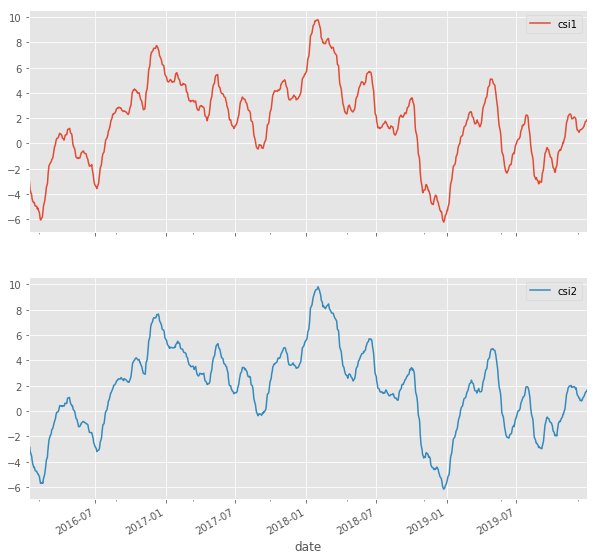

In [21]:
with plt.style.context(("ggplot")):
    df_subset.plot(y=["csi1", "csi2"], figsize=(10,10), subplots=True)

## Loading Grangers Causality Matrix Data

In [7]:
# Create grangers causality matrix for all tickers

# gc_test = grangers_causality_matrix(df_subset)

gc_test = pd.read_csv('CSI_SP500_granger_causality_FULL.csv', index_col = 0) # I ran the function previously (it took a long time)
print("Dataset Size : ", gc_test.shape)
gc_test.head()
#grangers_result = grangers_causality_matrix(df_subset)
#grangers_result.to_csv("grangers_result.csv")
#grangers_result.head()

Dataset Size :  (403, 403)


,A_x,AAL_x,AAP_x,AAPL_x,ABC_x,ABMD_x,ABT_x,ACN_x,ADBE_x,ADI_x,ADM_x,ADP_x,ADSK_x,AEE_x,AEP_x,AES_x,AFL_x,AIG_x,AIZ_x,AJG_x,AKAM_x,ALB_x,ALGN_x,ALK_x,ALL_x,ALXN_x,AMAT_x,AMD_x,AME_x,AMGN_x,AMP_x,AMT_x,AMZN_x,ANSS_x,ANTM_x,AON_x,APA_x,APD_x,APH_x,ARE_x,ATO_x,ATVI_x,AVB_x,AVY_x,AXP_x,AZO_x,BA_x,BAC_x,BAX_x,BBY_x,BDX_x,BIIB_x,BIO_x,BK_x,BKNG_x,BKR_x,BLK_x,BLL_x,BMY_x,BSX_x,BWA_x,BXP_x,C_x,CAG_x,CAH_x,CAT_x,CB_x,CCI_x,CCL_x,CDNS_x,CE_x,CERN_x,CF_x,CHD_x,CHRW_x,CI_x,CINF_x,CL_x,CLX_x,CMA_x,CMCSA_x,CME_x,CMI_x,CNC_x,CNP_x,COF_x,COG_x,COO_x,COP_x,COST_x,CPB_x,CPRT_x,CRM_x,CSCO_x,CSX_x,CTAS_x,CTL_x,CTSH_x,CTXS_x,CVS_x,CVX_x,D_x,DD_x,DE_x,DGX_x,DHI_x,DHR_x,DIS_x,DISCA_x,DISH_x,DLR_x,DLTR_x,DOV_x,DPZ_x,DRI_x,DTE_x,DUK_x,DVA_x,DVN_x,DXC_x,DXCM_x,EA_x,EBAY_x,ECL_x,ED_x,EFX_x,EIX_x,EL_x,EMN_x,EMR_x,EOG_x,EQIX_x,EQR_x,ES_x,ESS_x,ETFC_x,ETN_x,ETR_x,EW_x,EXC_x,EXPD_x,EXPE_x,EXR_x,F_x,FAST_x,FCX_x,FDX_x,FE_x,FFIV_x,FIS_x,FISV_x,FITB_x,FLIR_x,FMC_x,FRT_x,FTI_x,GD_x,GE_x,GILD_x,GIS_x,GL_x,GLW_x,GOOG_x,GOOGL_x,GPC_x,GPN_x,GPS_x,GRMN_x,GS_x,GWW_x,HAL_x,HAS_x,HBAN_x,HD_x,HES_x,HFC_x,HIG_x,HOLX_x,HON_x,HPQ_x,HRB_x,HRL_x,HSIC_x,HST_x,HSY_x,HUM_x,IBM_x,ICE_x,IDXX_x,IEX_x,IFF_x,ILMN_x,INCY_x,INTC_x,INTU_x,IP_x,IPG_x,IRM_x,ISRG_x,IT_x,ITW_x,IVZ_x,J_x,JBHT_x,JCI_x,JKHY_x,JNJ_x,JNPR_x,JPM_x,K_x,KEY_x,KLAC_x,KMB_x,KMX_x,KO_x,KR_x,KSS_x,KSU_x,LB_x,LEG_x,LEN_x,LH_x,LHX_x,LIN_x,LKQ_x,LLY_x,LMT_x,LNC_x,LOW_x,LRCX_x,LUV_x,LVS_x,LYV_x,MAA_x,MAR_x,MAS_x,MCD_x,MCHP_x,MCK_x,MCO_x,MDLZ_x,MDT_x,MET_x,MGM_x,MHK_x,MKC_x,MKTX_x,MLM_x,MMC_x,MMM_x,MNST_x,MO_x,MOS_x,MRK_x,MRO_x,MS_x,MSFT_x,MSI_x,MTB_x,MTD_x,MU_x,MXIM_x,MYL_x,NBL_x,NDAQ_x,NEE_x,NEM_x,NFLX_x,NI_x,NKE_x,NOC_x,NOV_x,NRG_x,NSC_x,NTAP_x,NTRS_x,NUE_x,NVDA_x,NWL_x,O_x,ODFL_x,OKE_x,OMC_x,ORCL_x,ORLY_x,OXY_x,PAYX_x,PBCT_x,PCAR_x,PEP_x,PFE_x,PG_x,PGR_x,PH_x,PHM_x,PKG_x,PKI_x,PLD_x,PNC_x,PNW_x,PPG_x,PPL_x,PRGO_x,PRU_x,PSA_x,PVH_x,PWR_x,PXD_x,QCOM_x,RCL_x,RE_x,REGN_x,RF_x,RJF_x,RL_x,RMD_x,ROK_x,ROP_x,ROST_x,RSG_x,SBAC_x,SBUX_x,SCHW_x,SEE_x,SHW_x,SIVB_x,SJM_x,SLB_x,SLG_x,SNA_x,SNPS_x,SO_x,SPG_x,SPGI_x,SRE_x,STE_x,STT_x,STX_x,STZ_x,SWK_x,SWKS_x,SYK_x,SYY_x,T_x,TAP_x,TDY_x,TFC_x,TFX_x,TGT_x,TIF_x,TJX_x,TMO_x,TPR_x,TROW_x,TRV_x,TSCO_x,TSN_x,TTWO_x,TXN_x,TXT_x,TYL_x,UAA_x,UHS_x,UNH_x,UNP_x,UPS_x,URI_x,USB_x,VAR_x,VFC_x,VLO_x,VMC_x,VRSN_x,VRTX_x,VTR_x,VZ_x,WAB_x,WAT_x,WBA_x,WDC_x,WEC_x,WELL_x,WFC_x,WHR_x,WLTW_x,WM_x,WMB_x,WMT_x,WRB_x,WST_x,WY_x,WYNN_x,XEL_x,XLNX_x,XOM_x,XRAY_x,XRX_x,YUM_x,ZBH_x,ZBRA_x,ZION_x,csi1_x,csi_difference_x
A_y,1.0000,0.5326,0.1110,0.0225,0.0051,0.0068,0.4126,0.9281,0.5480,0.1671,0.2060,0.2274,0.1408,0.0356,0.1362,0.0588,0.9212,0.0244,0.6572,0.6138,0.3622,0.2992,0.2046,0.6298,0.2904,0.3459,0.2258,0.0092,0.0051,0.0529,0.1519,0.0307,0.5942,0.1682,0.0732,0.1265,0.1785,0.1409,0.0809,0.1568,0.0336,0.0053,0.0337,0.1743,0.0904,0.3522,0.3893,0.3460,0.0381,0.1071,0.1866,0.6510,0.0098,0.3929,0.4455,0.7606,0.7437,0.1266,0.1341,0.2509,0.4633,0.4313,0.5651,0.4503,0.0000,0.4203,0.2308,0.1709,0.1302,0.0267,0.0312,0.2498,0.0001,0.5346,0.0569,0.0816,0.7412,0.3190,0.4589,0.2398,0.0139,0.1130,0.5869,0.0490,0.1941,0.1975,0.4687,0.3036,0.2635,0.7802,0.2267,0.0455,0.2848,0.8317,0.3029,0.1498,0.1251,0.0114,0.0842,0.1213,0.1778,0.1585,0.5041,0.3339,0.1180,0.2330,0.2787,0.0018,0.1345,0.0987,0.1610,0.3347,0.8684,0.3509,0.2550,0.0907,0.0707,0.0827,0.3298,0.2111,0.0138,0.1845,0.0408,0.1449,0.0871,0.3424,0.0257,0.4579,0.1879,0.5456,0.0447,0.0938,0.1103,0.1016,0.0378,0.5572,0.6301,0.0479,0.2855,0.2672,0.0055,0.6945,0.0654,0.2431,0.6531,0.5590,0.3427,0.2084,0.6928,0.0866,0.4217,0.8936,0.1528,0.0007,0.1959,0.6255,0.7766,0.6616,0.4464,0.4787,0.8642,0.0368,0.0048,0.0041,0.0371,0.4240,0.0439,0.1587,0.6598,0.3776,0.0928,0.0041,0.6668,0.1303,0.4556,0.0920,0.7028,0.6568,0.1564,0.0253,0.0845,0.5689,0.3971,0.0937,0.6109,0.0154,0.0458,0.6349,0.0979,0.0096,0.1861,0.0643,0.4447,0.2891,0.0115,0.0444,0.2171,0.5650,0.7845,0.3547,0.3572,0.5552,0.1756,0.7853,0.1936,0.2400,0.1354,0.9316,0.7633,0.7140,0.5691,0.0286,0.5375,0.0239,0.1741,0.4342,0.1680,

## Filtering Training Data Based on X & Y values of CSI1 from Grangers Causality Matrix

In [8]:
## Columns has been first filtered with values less than 0.05, then columns are sorted according to
## p-values in ascending order so that least p-values will be in begining and most at last.
csi1_x_columns = gc_test[gc_test["csi1_x"] < 0.05].sort_values(by="csi1_x").index.tolist()
csi1_x_columns = [val.split("_")[0] for val in csi1_x_columns]
print("Number of Columns : ", len(csi1_x_columns))
print("\nColumns : ",csi1_x_columns)

csi1_y_columns = gc_test.T[gc_test.T["csi1_y"] < 0.05].sort_values(by="csi1_y").index.tolist()
csi1_y_columns = [val.split("_")[0] for val in csi1_y_columns]
print("\nNumber of Columns : ", len(csi1_y_columns))
print("\nColumns : ", csi1_y_columns)

Number of Columns :  131

Columns :  ['csi', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'NKE', 'CTXS', 'MRO', 'ODFL', 'DLR', 'INTU', 'DVA', 'TSN', 'BAC', 'PFE', 'ALB', 'MS', 'WRB', 'LRCX', 'GPN', 'AMD', 'VTR', 'GOOG', 'NVDA', 'COO', 'SLG', 'AMZN', 'SPG', 'AAP', 'HUM', 'SPGI', 'NOV', 'EFX', 'PPL', 'RF', 'FRT', 'GL', 'STT', 'AEE', 'AZO', 'PHM', 'MRK', 'SCHW', 'IBM', 'CME', 'SIVB', 'RMD', 'HBAN', 'URI', 'CAT', 'CERN', 'DPZ', 'TFC', 'TXT', 'FMC', 'ZION', 'ATO', 'BLK', 'AIG', 'CPRT', 'IP', 'NFLX', 'ADP', 'PH', 'CMA', 'PGR', 'KEY', 'DE', 'HSY', 'EXPE', 'MCO', 'RCL', 'EA', 'CMCSA', 'BSX']

Number of Columns :  108

C

### Dataset Based on CSI1_X

In [9]:
cols_x = ["csi1", "csi2"] + [col for col in df_subset.columns if col in csi1_x_columns]
df_subset_csi_x = df_subset[cols_x]
print("Dataset Size : ", df_subset_csi_x.shape)
df_subset_csi_x.head()

Dataset Size :  (1000, 132)


,csi1,csi2,AAP,AAPL,ADBE,ADP,ADSK,AEE,AIG,AKAM,ALB,AMD,AMP,AMZN,APA,ARE,ATO,ATVI,AVB,AZO,BAC,BLK,BSX,BXP,CAH,CAT,CERN,CHD,CLX,CMA,CMCSA,CME,COO,COST,CPRT,CTAS,CTXS,DE,DLR,DPZ,DVA,DVN,EA,ECL,EFX,EOG,EQR,ESS,EXC,EXPE,EXR,FE,FIS,FLIR,FMC,FRT,GL,GOOG,GOOGL,GPN,HAL,HBAN,HD,HES,HRB,HST,HSY,HUM,IBM,INTU,IP,K,KEY,LNC,LRCX,MAA,MCO,MDT,MOS,MRK,MRO,MS,MSFT,NBL,NFLX,NKE,NOV,NVDA,O,ODFL,OXY,PEP,PFE,PGR,PH,PHM,PLD,PPL,PRU,PSA,PWR,PXD,RCL,RE,RF,RJF,RMD,SCHW,SIVB,SLB,SLG,SPG,SPGI,STT,TDY,TFC,TSN,TTWO,TXT,TYL,URI,USB,VLO,VRSN,VTR,WELL,WM,WRB,WST,WY,XLNX,ZION
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12,-2.634912,-2.410424,0.764587,0.516162,0.463803,0.410358,0.282919,0.224001,0.299287,0.242074,0.252763,0.012341,0.496489,3.190592,0.182898,0.431375,0.320613,0.191676,0.926934,3.764277,0.079056,1.619281,0.091862,0.624858,0.412527,0.318083,0.305484,0.216178,0.663018,0.198854,0.141666,0.450532,0.658887,0.805845,0.090803,0.448466,0.291079,0.384798,0.403181,0.566766,0.348291,0.132810,0.338841,0.545905,0.528865,0.324899,0.412785,1.212331,0.144273,0.577817,0.467365,0.166168,0.309770,0.160591,0.159210,0.756016,0.282092,3.749200,3.848704,0.302179,0.162501,0.052566,0.658319,0.204482,0.166890,0.073996,0.438965,0.871786,0.686254,0.489776,0.187700,0.369049,0.062222,0.224620,0.368894,0.466229,0.470774,0.394712,0.126820,0.267273,0.047454,0.146959,0.272539,0.147682,0.601983,0.309512,0.157131,0.155840,0.270732,0.190575,0.314295,0.504079,0.160074,0.158680,0.467365,0.083807,0.210110,0.173242,0.377569,1.291800,0.095528,0.584736,0.485490,0.907054,0.045131,0.261799,0.274347,0.150986,0.538521,0.334297,0.531705,0.958071,0.458122,0.306465,0.434060,0.180213,0.276670,0.173603,0.201797,0.846380,0.316431,0.209749,0.367603,0.409429,0.288599,0.351286,0.274708,0.175118,0.289476,0.139523,0.223898,0.123980
2016-01-13,-3.026368,-2.782623,0.752846,0.515755,0.467616,0.409575,0.269396,0.228459,0.300111,0.242652,0.252661,0.011915,0.489382,3.081131,0.188529,0.430440,0.326961,0.184610,0.937351,3.729280,0.078907,1.613144,0.092941,0.628767,0.413970,0.322459,0.308902,0.208256,0.678441,0.194196,0.141794,0.445745,0.664354,0.805592,0.091378,0.449134,0.283681,0.387756,0.411111,0.571731,0.350209,0.131335,0.335646,0.546153,0.535084,0.339829,0.419266,1.238045,0.145845,0.563311,0.474236,0.166817,0.313086,0.165652,0.157679,0.777472,0.283430,3.710004,3.810676,0.298681,0.161309,0.051634,0.642906,0.204364,0.167081,0.071281,0.442726,0.867924,0.694646,0.485622,0.190912,0.375470,0.061855,0.221257,0.365832,0.472912,0.461314,0.395329,0.127840,0.268284,0.045226,0.142403,0.273473,0.147964,0.564317,0.311285,0.154001,0.154954,0.274533,0.187082,0.319321,0.511042,0.160832,0.159456,0.475136,0.086321,0.214479,0.177408,0.380342,1.320500,0.095747,0.604777,0.471535,0.915003,0.044114,0.256951,0.281311,0.146746,0.524758,0.338664,0.540963,0.975851,0.446804,0.300853,0.418366,0.178573,0.281311,0.172112,0.200974,0.834084,0.305778,0.206588,0.344384,0.402955,0.288831,0.352592,0.276757,0.175184,0.295504,0.141662,0.221946,0.121220
2016-01-14,-3.310585,-2.833131,0.736310,0.518522,0.467879,0.411556,0.274319,0.227739,0.298546,0.244412,0.254780,0.011515,0.495441,3.089668,0.192935,0.422081,0.328140,0.184442,0.917939,3.712864,0.078101,1.615172,0.094618,0.624551,0.426093,0.324441,0.303183,0.203798,0.663367,0.192414,0.143412,0.441307,0.646277,0.798103,0.090606,0.445683,0.279555,0.383473,0.408274,0.558224,0.351430,0.135258,0.335956,0.546137,0.539051,0.340020,0.409368,1.202678,0.145418,0.560986,0.454437,0.169645,0.314177,0.165373,0.159787,0.766165,0.280884,3.723858,3.810712,0.298859,0.165894,0.051321,0.623248,0.208201,0.168447,0.071797,0.440629,0.871307,0.692492,0.491429,0.190382,0.373417,0.061637,0.216277,0.374876,0.465743,0.459126,0.389673,0.130568,0.269890,0.047257,0.141458,0.276715,0.151461,0.557808,0.304851,0.158964,0.149377,0.272235,0.183713,0.332888,0.499192,0.162090,0.157453,0.472308,0.083728,0.206586,0.177982,0.375501,1.301151,

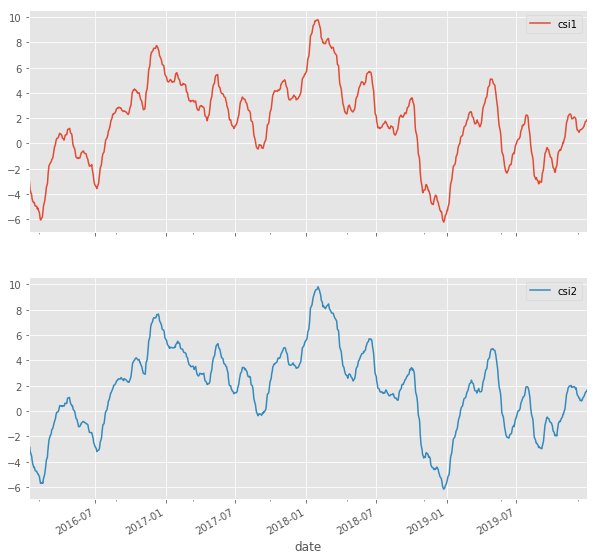

In [10]:
with plt.style.context(("ggplot")):
    df_subset_csi_x.plot(y=["csi1", "csi2"], figsize=(10,10), subplots=True)

#### Correlation Between Tickers & CSI1,CSI2 [CSI1_X]

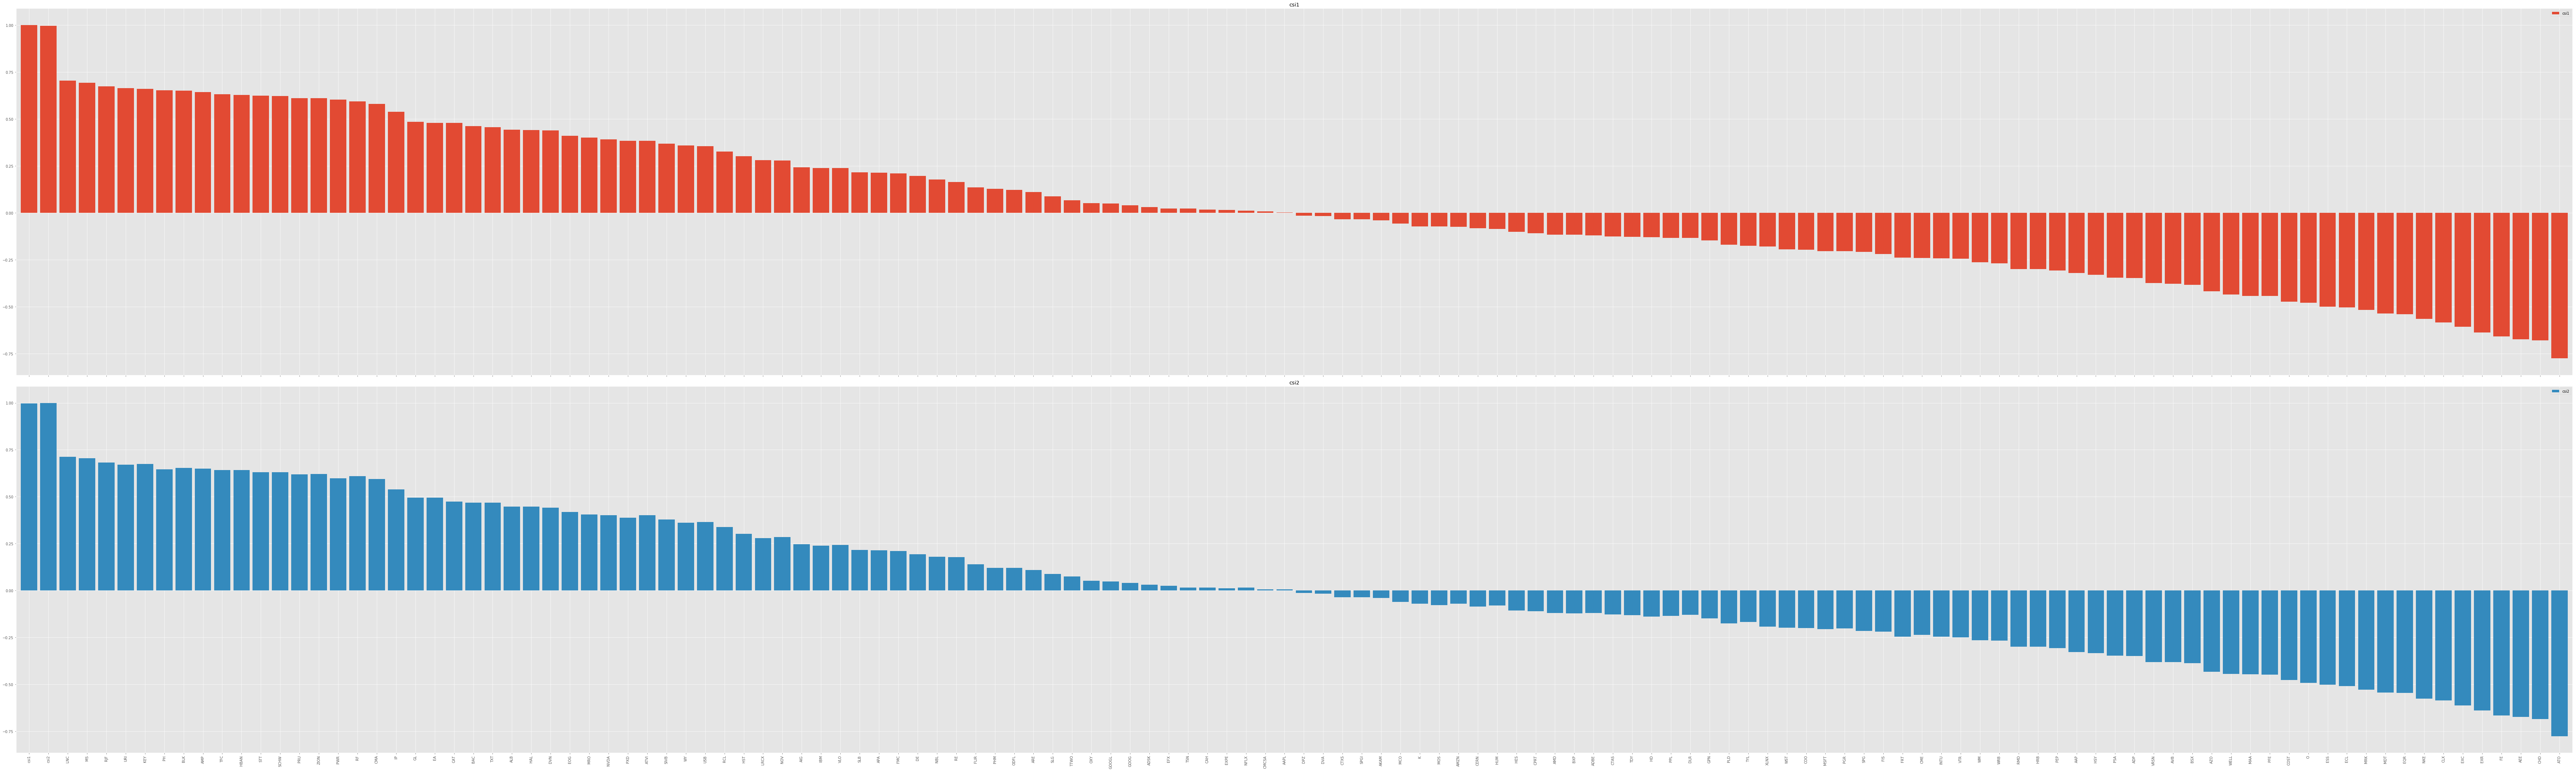

In [26]:
with plt.style.context("ggplot"):
    corr_csi = df_subset_csi_x.corr()[["csi1", "csi2"]]

    corr_csi.sort_values(by="csi1", ascending=False).plot.bar(y=["csi1", "csi2"], width=0.85, subplots=True, figsize=(100,30))

    plt.tight_layout()

    plt.savefig("correlation_csi1_x.png", dpi=150);

### Dataset Based on CSI1_Y

In [11]:
cols_y = ["csi1", "csi2"] + [col for col in df_subset.columns if col in csi1_y_columns]
df_subset_csi_y = df_subset[cols_y]
print("Dataset Size : ", df_subset_csi_y.shape)
df_subset_csi_y.head()

Dataset Size :  (1000, 109)


,csi1,csi2,AAPL,ADM,AIZ,AJG,ALB,AMD,AME,AMT,AMZN,AVY,BIIB,BKNG,BWA,CAT,CDNS,CF,CHRW,CINF,CL,CLX,CME,CMI,CNC,CNP,COF,CSCO,DGX,DISH,DLR,DPZ,DVA,DXC,EBAY,ECL,EMN,EMR,EOG,EQIX,ETN,EW,FCX,FDX,GIS,GOOG,GOOGL,GRMN,GWW,HD,HOLX,INTU,IP,IPG,IT,ITW,J,JBHT,JKHY,JNJ,KO,KSS,LHX,LKQ,LNC,LRCX,LVS,MAS,MCD,MHK,MMM,MSFT,MTD,MXIM,MYL,NBL,NDAQ,NUE,PCAR,PH,PHM,PKG,PPG,PPL,PVH,PWR,PXD,RE,RL,ROK,SEE,SHW,SNA,SNPS,SWK,SYK,SYY,TIF,TSN,TXN,TXT,URI,VAR,VLO,VTR,WAB,WHR,XLNX,YUM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12,-2.634912,-2.410424,0.516162,0.176960,0.401683,0.195601,0.252763,0.012341,0.250284,0.487865,3.190592,0.309305,1.438965,5.932666,0.193122,0.318083,0.098833,0.168026,0.325209,0.290561,0.327275,0.663018,0.450532,0.447330,0.162759,0.089332,0.339771,0.130900,0.352370,0.278529,0.403181,0.566766,0.348291,0.133157,0.135340,0.545905,0.325364,0.228338,0.324899,1.626149,0.257926,0.133826,0.021223,0.695601,0.291077,3.749200,3.848704,0.171176,0.968966,0.658319,0.189249,0.489776,0.187700,0.113859,0.447434,0.432665,0.201694,0.349633,0.402251,0.507281,0.217495,0.259372,0.459104,0.139523,0.224620,0.368894,0.200919,0.131777,0.606424,0.924145,0.727357,0.272539,1.636993,0.171176,0.258649,0.147682,0.297325,0.187390,0.233347,0.467365,0.083807,0.307239,0.491170,0.173242,0.361820,0.095528,0.584736,0.907054,0.536817,0.487039,0.215171,1.272436,0.851131,0.216978,0.505577,0.458174,0.210162,0.353248,0.276670,0.266085,0.201797,0.316431,0.345761,0.367603,0.288599,0.327016,0.693535,0.223898,0.258259
2016-01-13,-3.026368,-2.782623,0.515755,0.177249,0.415453,0.195943,0.252661,0.011915,0.250966,0.488005,3.081131,0.310703,1.415294,5.819520,0.179209,0.322459,0.098819,0.168194,0.331992,0.292538,0.333157,0.678441,0.445745,0.449611,0.162209,0.090399,0.337023,0.130276,0.353122,0.275751,0.411111,0.571731,0.350209,0.132028,0.134565,0.546153,0.332098,0.229095,0.339829,1.618281,0.256474,0.132059,0.019806,0.689986,0.292856,3.710004,3.810676,0.171901,0.982895,0.642906,0.187841,0.485622,0.190912,0.114812,0.445268,0.436795,0.202563,0.348091,0.401313,0.513795,0.221628,0.264683,0.452259,0.134407,0.221257,0.365832,0.195785,0.129958,0.609649,0.897633,0.734629,0.273473,1.650056,0.170047,0.258910,0.147964,0.295133,0.188635,0.234603,0.475136,0.086321,0.305301,0.492771,0.177408,0.370439,0.095747,0.604777,0.915003,0.533708,0.492348,0.215908,1.277128,0.855320,0.214637,0.509612,0.472965,0.212043,0.353228,0.281311,0.263835,0.200974,0.305778,0.349729,0.344384,0.288831,0.326484,0.688238,0.221946,0.262809
2016-01-14,-3.310585,-2.833131,0.518522,0.173813,0.413328,0.196426,0.254780,0.011515,0.250039,0.480436,3.089668,0.312249,1.461835,5.842651,0.171208,0.324441,0.100974,0.169958,0.328922,0.292763,0.331006,0.663367,0.441307,0.451623,0.163028,0.091856,0.336581,0.128484,0.348565,0.269525,0.408274,0.558224,0.351430,0.132780,0.134737,0.546137,0.333247,0.228365,0.340020,1.620330,0.251758,0.133903,0.021883,0.686188,0.288386,3.723858,3.810712,0.172823,0.984526,0.623248,0.184234,0.491429,0.190382,0.116240,0.445006,0.431564,0.199969,0.341583,0.401813,0.515240,0.218205,0.256343,0.440213,0.134528,0.216277,0.374876,0.195123,0.129995,0.607617,0.888709,0.735581,0.276715,1.618611,0.168343,0.264159,0.151461,0.299536,0.188715,0.238160,0.472308,0.083728,0.303027,0.487522,0.177982,0.358360,0.093941,0.604179,0.909446,0.526442,0.482415,0.215287,1.267337,0.849685,0.214922,0.509665,0.473714,0.209087,0.348356,0.275673,0.260668,0.197780,0.297713,0.347507,0.350753,0.284687,0.330120,0.698328,0.220966,0.262235
2016-01-15,-3.678765,-3.172755,0.517172,0.167776,0.416751,0.200256,0.255098,0.010809,0.254992,0.470635,3.035941,0.313828,1.455354,5.786380,0.165433,0.318780,0.101166,0.168095,0.338427,0.293488,0.337309,0.675470,0.451041,0.449124,0.162159,0.092114,0.334647,0.125765,0.350194,0.265907,0.406368,0.554603,0.353922,0.133850,0.134498,0.546190,0.328737,0.229434,0.335286,1.614344,0.254832,0.132563,0.023162,0.675789,0.291465,3.697620,3.783025,0.173154,1.0085

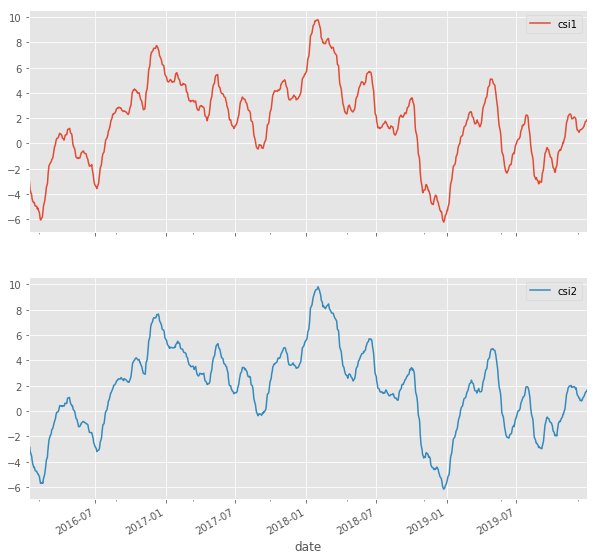

In [28]:
with plt.style.context(("ggplot")):
    df_subset_csi_y.plot(y=["csi1", "csi2"], figsize=(10,10), subplots=True)

#### Correlation Between Tickers & CSI1,CSI2 [CSI1_Y]

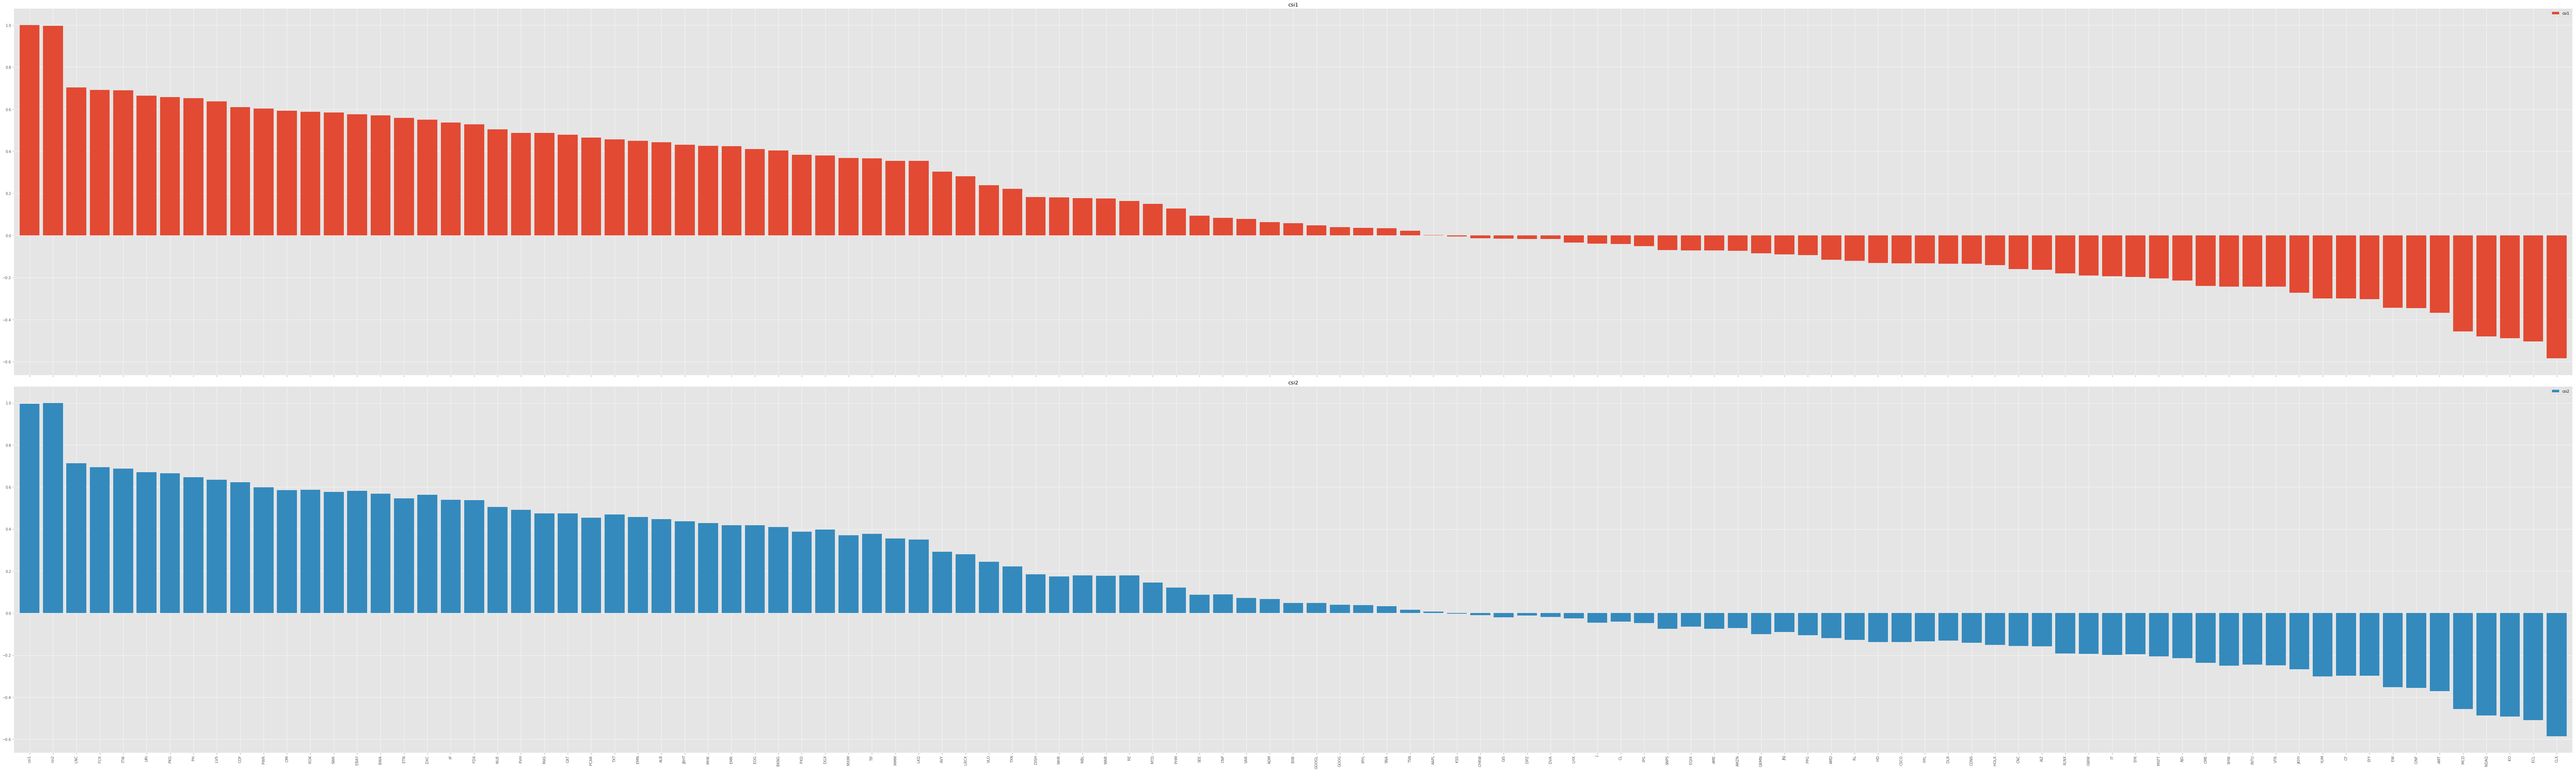

In [29]:
with plt.style.context("ggplot"):
    corr_csi = df_subset_csi_y.corr()[["csi1", "csi2"]]

    corr_csi.sort_values(by="csi1", ascending=False).plot.bar(y=["csi1", "csi2"], width=0.85, subplots=True, figsize=(100,30))

    plt.tight_layout()

    plt.savefig("correlation_csi1_y.png", dpi=150);

## Testing for Stationarity of Time Series [CSI1 & CSI2]

### CSI1

In [30]:
dftest = adfuller(df_subset['csi1'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.054647691314602
2. P-Value :  0.0011498983311168398
2. P-Value : 0.001
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 996
5. Critical Values :
	 1% :  -3.4369325637409154
	 5% :  -2.8644462162311934
	 10% :  -2.568317409920808


P-value of `0.001` is less than `0.05` implies that time-series is **stationary**.

### CSI2

In [31]:
dftest = adfuller(df_subset['csi2'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.58842699993108
2. P-Value :  0.005986172342860774
2. P-Value : 0.006
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 991
5. Critical Values :
	 1% :  -3.4369658620871286
	 5% :  -2.8644609013346485
	 10% :  -2.56832523159495


P-value of `0.005` is less than `0.05` implies that time-series is **stationary**.

## Method 1 : Using CSI1_X to Determine Columns of Data

### Dividing Dataset into Train/Test Sets

In [32]:
# "Difference" the data (statistics term)
n_obs=5 ## Beyond 5 results detriorate for majority of predictions

final_cols = df_subset_csi_x.columns[:46] ## Beyond 46 , it fails with memory error.

X_train, X_test = df_subset_csi_x[final_cols][0:-n_obs], df_subset_csi_x[final_cols][-n_obs:]
print(X_train.shape, X_test.shape)

(995, 46) (5, 46)


### Differencing Time-Series to Remove Trend/Seasonality i.e converting it to Stationary Time-Series

In [33]:
X_train_transformed = X_train.diff().dropna()
print("Dataset Size : ", X_train_transformed.shape)
X_train_transformed.head()

Dataset Size :  (994, 46)


,csi1,csi2,AAP,AAPL,ADBE,ADP,ADSK,AEE,AIG,AKAM,ALB,AMD,AMP,AMZN,APA,ARE,ATO,ATVI,AVB,AZO,BAC,BLK,BSX,BXP,CAH,CAT,CERN,CHD,CLX,CMA,CMCSA,CME,COO,COST,CPRT,CTAS,CTXS,DE,DLR,DPZ,DVA,DVN,EA,ECL,EFX,EOG
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13,-0.391457,-0.372198,-0.011741,-0.000407,0.003814,-0.000784,-0.013523,0.004459,0.000824,0.000578,-0.000101,-0.000426,-0.007107,-0.109461,0.005632,-0.000935,0.006347,-0.007066,0.010417,-0.034997,-0.000149,-0.006137,0.001079,0.003909,0.001443,0.004376,0.003418,-0.007922,0.015423,-0.004658,0.000128,-0.004787,0.005467,-0.000253,0.000575,0.000668,-0.007399,0.002958,0.007930,0.004965,0.001918,-0.001475,-0.003195,0.000247,0.006219,0.014930
2016-01-14,-0.284217,-0.050508,-0.016536,0.002767,0.000263,0.001982,0.004923,-0.000720,-0.001565,0.001760,0.002119,-0.000401,0.006059,0.008537,0.004406,-0.008359,0.001180,-0.000168,-0.019412,-0.016416,-0.000806,0.002028,0.001677,-0.004216,0.012123,0.001982,-0.005719,-0.004458,-0.015074,-0.001782,0.001617,-0.004438,-0.018077,-0.007489,-0.000773,-0.003451,-0.004126,-0.004283,-0.002837,-0.013507,0.001221,0.003923,0.000310,-0.000016,0.003966,0.000190
2016-01-15,-0.368180,-0.339624,0.031966,-0.001351,0.006909,0.003331,-0.011287,0.003931,0.000107,-0.009334,0.000318,-0.000706,-0.001165,-0.053728,-0.004819,0.004733,0.007145,0.001437,0.017581,0.039545,-0.001109,-0.036023,0.000532,0.006140,0.006472,-0.005662,-0.000910,0.006334,0.012103,-0.000465,0.000058,0.009734,0.002570,0.002653,-0.000861,0.001737,0.001553,0.005857,-0.001906,-0.003621,0.002491,-0.004860,0.015783,0.000054,0.008630,-0.004734
2016-01-19,-0.382999,-0.382063,0.000733,-0.003187,-0.000578,0.005776,-0.009974,-0.000627,-0.000025,0.006547,0.002373,-0.000440,-0.002199,0.018829,-0.004770,0.000549,0.004819,0.001029,0.012848,0.053344,-0.001272,-0.015818,-0.001722,0.003841,0.001233,-0.004890,-0.002422,-0.000200,0.003250,-0.007327,0.000766,0.006845,-0.005382,-0.000639,-0.001209,-0.003413,-0.001348,-0.004027,-0.007028,0.003304,-0.004512,-0.005544,0.006498,-0.001843,0.004589,-0.011027
2016-01-20,-0.273654,-0.275372,0.003358,0.007372,-0.000523,0.000667,0.004955,-0.003034,-0.002102,0.006746,0.001134,-0.000673,0.001378,0.025058,0.003080,-0.015567,-0.004042,0.000056,-0.024478,0.038362,-0.001980,0.009521,0.001051,-0.010508,-0.001371,0.002890,0.001953,0.001540,-0.003309,-0.001535,0.000149,-0.004344,0.025213,0.001499,0.000745,-0.000484,0.005476,0.002524,-0.008067,0.015538,0.002920,-0.008560,0.001849,0.007443,-0.004573,0.000223


### Stationarity Test on Transformed Time-Series

#### CSI1

In [34]:
dftest = adfuller(X_train_transformed['csi1'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.800776486722231
2. P-Value :  2.1152438538136786e-14
2. P-Value : 0.000
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 993
5. Critical Values :
	 1% :  -3.4369525024039884
	 5% :  -2.8644550095200705
	 10% :  -2.568322093455802


P-value of `2.11e-14` is less than 0.05 implies that time-series is **stationary**.

#### CSI2

In [35]:
dftest = adfuller(X_train_transformed['csi2'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.487783858591548
2. P-Value :  4.590095304550526e-11
2. P-Value : 0.000
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 986
5. Critical Values :
	 1% :  -3.4369994990319355
	 5% :  -2.8644757356011743
	 10% :  -2.5683331327427803


P-value of `4.59e-11` is less than 0.05 implies that time-series is **stationary**.

### Fitting VAR Model on Transformed Train Data

In [36]:
model = VAR(X_train_transformed)
res = model.fit(maxlags=15, ic='aic')

#aic : Akaike
#fpe : Final prediction error
#hqic : Hannan-Quinn
#bic : Bayesian a.k.a. Schwarz

print(res.summary())

/home/sunny/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     17:16:42
--------------------------------------------------------------------
No. of Equations:         46.0000    BIC:                   -470.610
Nobs:                     993.000    HQIC:                  -477.224
Log likelihood:           176303.    FPE:               9.63782e-210
AIC:                     -481.280    Det(Omega_mle):    1.14845e-210
--------------------------------------------------------------------
Results for equation csi1
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.002319         0.003196            0.726           0.468
L1.csi1          0.894478         0.042838           20.880           0.000
L1.csi2         -0.042608         0.043474           -0.980           0.327
L1.AA

### Plotting Prediction vs Residuals

#### CSI1

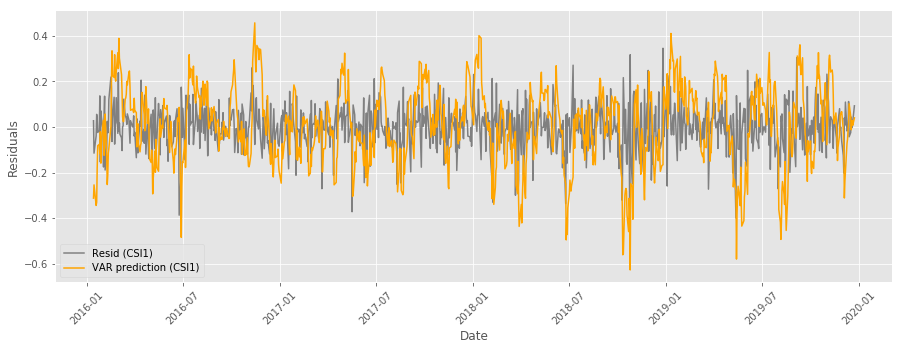

In [37]:
with plt.style.context(("ggplot")):
    y_fitted = res.fittedvalues
    plt.figure(figsize = (15,5))
    plt.plot(res.resid[["csi1"]], label='Resid (CSI1)', color="gray")
    plt.plot(y_fitted["csi1"], label='VAR prediction (CSI1)', color="orange")
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.legend()

#### CSI2

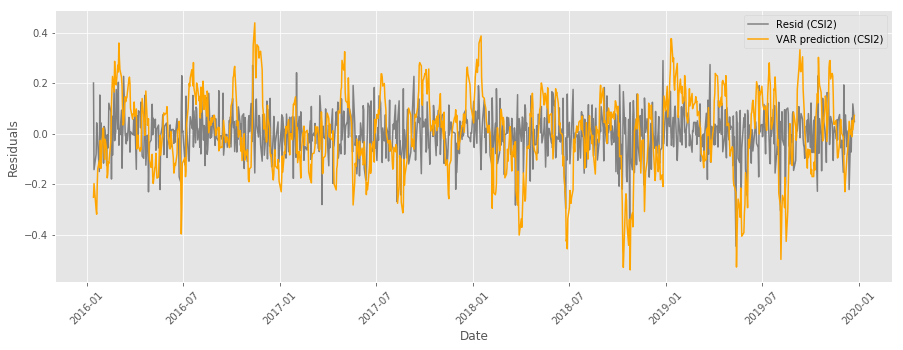

In [38]:
with plt.style.context(("ggplot")):
    y_fitted = res.fittedvalues
    plt.figure(figsize = (15,5))
    plt.plot(res.resid[["csi2"]], label='Resid (CSI2)', color="gray")
    plt.plot(y_fitted["csi2"], label='VAR prediction (CSI2)', color="orange")
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.legend()

### Durbin Watson Test

In [39]:
out = durbin_watson(res.resid)
out.shape

(46,)

In [40]:
for col, val in zip(final_cols, out):
    print(col , " : ", val)

csi1  :  2.023496143091801
csi2  :  2.1582914695835926
AAP  :  1.9879134968646426
AAPL  :  1.987140149471677
ADBE  :  1.9868656676443583
ADP  :  2.016728580280462
ADSK  :  1.978661675326989
AEE  :  2.0060735659122044
AIG  :  1.9760288205452055
AKAM  :  1.9887855143289226
ALB  :  1.9983907186386036
AMD  :  1.9872838561234798
AMP  :  2.025444955602128
AMZN  :  1.9973771699198584
APA  :  1.9978742951897166
ARE  :  2.014126249229383
ATO  :  1.995056616142232
ATVI  :  1.9863686499036048
AVB  :  1.9685844939529307
AZO  :  2.007678500514826
BAC  :  2.011443443262101
BLK  :  2.0269593638137846
BSX  :  2.016114943759599
BXP  :  2.022929546636453
CAH  :  1.9854180573992157
CAT  :  1.9833122166471253
CERN  :  1.9823887640989628
CHD  :  2.0075325718197905
CLX  :  1.985418652560108
CMA  :  2.000621866762603
CMCSA  :  2.003053622635508
CME  :  2.010866529991077
COO  :  1.9729285783542803
COST  :  1.98883844891155
CPRT  :  2.0179624723934095
CTAS  :  2.0088751446896214
CTXS  :  2.0123859959064747
DE 

### Future Prediction

In [41]:
lag_order = res.k_ar

print("Lag samples to use for future predictions : ", lag_order)
# Input data for forecasting
input_data = X_train_transformed.values[-lag_order:]
#print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
pred

Lag samples to use for future predictions :  1


,csi1_pred,csi2_pred,AAP_pred,AAPL_pred,ADBE_pred,ADP_pred,ADSK_pred,AEE_pred,AIG_pred,AKAM_pred,ALB_pred,AMD_pred,AMP_pred,AMZN_pred,APA_pred,ARE_pred,ATO_pred,ATVI_pred,AVB_pred,AZO_pred,BAC_pred,BLK_pred,BSX_pred,BXP_pred,CAH_pred,CAT_pred,CERN_pred,CHD_pred,CLX_pred,CMA_pred,CMCSA_pred,CME_pred,COO_pred,COST_pred,CPRT_pred,CTAS_pred,CTXS_pred,DE_pred,DLR_pred,DPZ_pred,DVA_pred,DVN_pred,EA_pred,ECL_pred,EFX_pred,EOG_pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24,0.097930,0.081624,-0.001756,0.000784,-0.003534,0.001256,0.001499,0.000698,0.000684,0.001821,-0.002367,-0.000388,0.000228,0.012656,0.000427,0.001142,0.001672,0.000658,0.002991,0.003673,-0.000228,-0.001738,0.000167,-0.000114,0.000056,0.000119,-0.000478,0.001329,0.001818,-0.000988,0.000047,-0.001870,-0.001510,-0.000007,-0.000088,0.001336,-0.000682,0.002544,0.000620,0.002487,0.000551,-0.000692,-0.000374,0.000333,-0.000141,-0.000967
2019-12-26,0.091868,0.088659,0.000129,0.000480,0.001315,0.000129,0.000155,-0.000115,-0.000183,-0.000140,0.000462,0.000327,0.000351,0.003013,0.000103,-0.000176,-0.000295,0.000166,-0.001463,-0.000585,0.000043,0.000243,-0.000167,-0.000797,-0.000127,0.000331,-0.000025,-0.000455,-0.000768,0.000172,-0.000002,-0.000242,0.001190,-0.001278,0.000312,0.000363,0.000372,0.000086,-0.000474,0.001182,0.000096,0.000047,0.000446,-0.000524,0.000198,0.000021
2019-12-27,0.080685,0.078097,-0.000201,0.000352,0.000234,-0.000035,0.000186,0.000004,-0.000074,-0.000128,-0.000323,0.000152,0.000191,0.001144,0.000064,0.000167,0.000042,-0.000254,-0.000136,-0.000090,0.000084,0.000287,0.000042,-0.000166,-0.000100,0.000144,-0.000061,-0.000102,-0.000445,0.000115,0.000019,-0.000021,-0.000091,0.000238,0.000077,0.000121,0.000053,0.000325,-0.000067,0.000323,-0.000070,0.000022,-0.000154,-0.000080,-0.000023,0.000072
2019-12-30,0.068793,0.068741,-0.000104,0.000280,0.000317,0.000018,0.000124,0.000082,-0.000076,-0.000117,-0.000165,0.000126,0.000214,0.002406,0.000019,0.000156,0.000089,-0.000128,-0.000300,-0.000212,0.000067,0.000247,0.000009,-0.000194,-0.000091,0.000195,-0.000058,-0.000038,-0.000273,0.000156,0.000003,-0.000057,-0.000019,0.000092,0.000134,0.000285,0.000067,0.000196,-0.000138,0.000360,-0.000014,0.000049,-0.000104,-0.000083,-0.000100,0.000071
2019-12-31,0.059627,0.059968,-0.000113,0.000308,0.000430,0.000026,0.000170,0.000050,-0.000092,-0.000103,-0.000186,0.000134,0.000187,0.002303,-0.000002,0.000152,0.000054,-0.000110,-0.000297,-0.000015,0.000066,0.000166,0.000019,-0.000189,-0.000148,0.000173,-0.000063,-0.000048,-0.000311,0.000129,0.000008,0.000001,0.000052,0.000086,0.000138,0.000305,0.000087,0.000215,-0.000108,0.000424,-0.000055,0.000027,-0.000034,-0.000094,-0.000086,0.000032


### Inverting Predictions to Get Original Predictions

In [42]:
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, pred)

output

,csi1_pred,csi2_pred,AAP_pred,AAPL_pred,ADBE_pred,ADP_pred,ADSK_pred,AEE_pred,AIG_pred,AKAM_pred,ALB_pred,AMD_pred,AMP_pred,AMZN_pred,APA_pred,ARE_pred,ATO_pred,ATVI_pred,AVB_pred,AZO_pred,BAC_pred,BLK_pred,BSX_pred,BXP_pred,CAH_pred,CAT_pred,CERN_pred,CHD_pred,CLX_pred,CMA_pred,CMCSA_pred,CME_pred,COO_pred,COST_pred,CPRT_pred,CTAS_pred,CTXS_pred,DE_pred,DLR_pred,DPZ_pred,DVA_pred,DVN_pred,EA_pred,ECL_pred,EFX_pred,EOG_pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24,1.439758,1.228413,0.496251,0.884913,1.020530,0.530550,0.570953,0.236175,0.159360,0.269271,0.223117,0.141135,0.520993,5.594501,0.083018,0.496783,0.347572,0.183991,0.647689,3.782609,0.109261,1.553769,0.140943,0.422680,0.159230,0.462419,0.228150,0.219715,0.476073,0.222161,0.137336,0.630967,0.996778,0.913105,0.279689,0.844558,0.342261,0.547498,0.363673,0.899909,0.231638,0.080966,0.335191,0.598677,0.433954,0.258605
2019-12-26,1.531626,1.317072,0.496380,0.885393,1.021845,0.530680,0.571109,0.236061,0.159177,0.269130,0.223579,0.141462,0.521343,5.597514,0.083122,0.496607,0.347277,0.184156,0.646226,3.782025,0.109303,1.554012,0.140776,0.421884,0.159103,0.462750,0.228125,0.219260,0.475305,0.222333,0.137334,0.630725,0.997969,0.911828,0.280000,0.844922,0.342633,0.547584,0.363199,0.901091,0.231734,0.081013,0.335637,0.598153,0.434152,0.258627
2019-12-27,1.612311,1.395169,0.496179,0.885745,1.022079,0.530645,0.571295,0.236064,0.159103,0.269002,0.223256,0.141614,0.521534,5.598658,0.083185,0.496774,0.347319,0.183902,0.646091,3.781934,0.109387,1.554299,0.140818,0.421718,0.159003,0.462894,0.228064,0.219158,0.474860,0.222449,0.137353,0.630704,0.997877,0.912066,0.280077,0.845043,0.342686,0.547909,0.363133,0.901414,0.231664,0.081035,0.335482,0.598072,0.434130,0.258699
2019-12-30,1.681104,1.463910,0.496075,0.886025,1.022396,0.530663,0.571419,0.236146,0.159027,0.268885,0.223092,0.141739,0.521748,5.601064,0.083204,0.496930,0.347409,0.183773,0.645791,3.781722,0.109454,1.554546,0.140827,0.421523,0.158913,0.463089,0.228006,0.219120,0.474587,0.222605,0.137356,0.630648,0.997858,0.912158,0.280211,0.845329,0.342752,0.548105,0.362994,0.901774,0.231651,0.081085,0.335378,0.597990,0.434030,0.258770
2019-12-31,1.740731,1.523878,0.495962,0.886333,1.022826,0.530689,0.571589,0.236196,0.158935,0.268782,0.222905,0.141874,0.521934,5.603367,0.083202,0.497082,0.347462,0.183663,0.645494,3.781707,0.109519,1.554712,0.140846,0.421334,0.158765,0.463262,0.227943,0.219072,0.474276,0.222734,0.137364,0.630649,0.997910,0.912243,0.280349,0.845633,0.342839,0.548320,0.362886,0.902199,0.231595,0.081111,0.335344,0.597895,0.433943,0.258802


### Checking Model Performance

#### CSI1

In [43]:
#combining predicted and real data set
combine_csi1_x = pd.concat([output['csi1_pred'], X_test['csi1']], axis=1)
combine_csi1_x['accuracy'] = round(combine_csi1_x.apply(lambda row: row.csi1_pred /row.csi1 *100, axis = 1),2)
combine_csi1_x['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1_x['accuracy']],index = combine_csi1_x.index)
combine_csi1_x = combine_csi1_x.round(decimals=2).reset_index()
combine_csi1_x = combine_csi1_x.sort_values(by='date', ascending=False)
combine_csi1_x

,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.74,1.86,93.68%
3,2019-12-30,1.68,1.79,93.70%
2,2019-12-27,1.61,1.73,93.42%
1,2019-12-26,1.53,1.61,94.87%
0,2019-12-24,1.44,1.44,100.13%


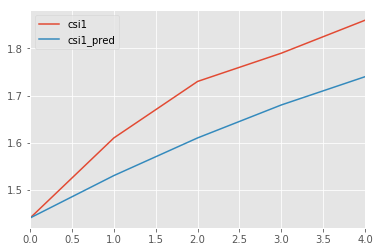

In [44]:
with plt.style.context("ggplot"):
    combine_csi1_x.plot(y=["csi1", "csi1_pred"])

In [45]:
#Forecast bias
forecast_errors = [combine_csi1_x['csi1'][i]- combine_csi1_x['csi1_pred'][i] for i in range(len(combine_csi1_x['csi1']))]
bias = sum(forecast_errors) * 1.0/len(combine_csi1_x['csi1'])
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values))
print('Mean squared error:', mean_squared_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values)))

Bias: 0.086000
Mean absolute error: 0.08600000000000003
Mean squared error: 0.009460000000000007
Root mean squared error: 0.09726253132630266


#### CSI2

In [46]:
#combining predicted and real data set
combine_csi2_x = pd.concat([output['csi2_pred'], X_test['csi2']], axis=1)
combine_csi2_x['accuracy'] = round(combine_csi2_x.apply(lambda row: row.csi2_pred /row.csi2 *100, axis = 1),2)
combine_csi2_x['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi2_x['accuracy']],index = combine_csi2_x.index)
combine_csi2_x = combine_csi2_x.round(decimals=2)
combine_csi2_x = combine_csi2_x.reset_index()
combine_csi2_x = combine_csi2_x.sort_values(by='date', ascending=False)
combine_csi2_x

,date,csi2_pred,csi2,accuracy
4,2019-12-31,1.52,1.65,92.57%
3,2019-12-30,1.46,1.56,93.71%
2,2019-12-27,1.40,1.48,94.40%
1,2019-12-26,1.32,1.37,95.89%
0,2019-12-24,1.23,1.22,100.67%


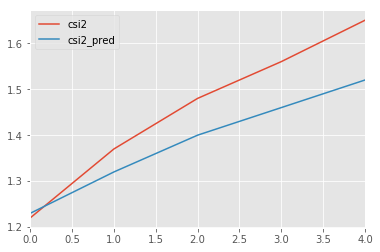

In [47]:
with plt.style.context("ggplot"):
    combine_csi2_x.plot(y=["csi2", "csi2_pred"])

In [48]:
#Forecast bias
forecast_errors = [combine_csi2_x['csi2'][i]- combine_csi2_x['csi2_pred'][i] for i in range(len(combine_csi2_x['csi2']))]
bias = sum(forecast_errors) * 1.0/len(combine_csi2_x['csi2'])
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine_csi2_x['csi2'].values, combine_csi2_x['csi2_pred'].values))
print('Mean squared error:', mean_squared_error(combine_csi2_x['csi2'].values, combine_csi2_x['csi2_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi2_x['csi2'].values, combine_csi2_x['csi2_pred'].values)))

Bias: 0.070000
Mean absolute error: 0.07400000000000002
Mean squared error: 0.007180000000000001
Root mean squared error: 0.08473488065725944


## Method 2 : Using CSI1_y to Determine Columns of Data

### Dividing Dataset into Train/Test Sets

In [49]:
# "Difference" the data (statistics term)
n_obs=5 ## Beyond 5 results detriorate for majority of predictions

final_cols = df_subset_csi_y.columns[:47] ## Beyond 47 , it fails with memory error.

X_train, X_test = df_subset_csi_y[final_cols][0:-n_obs], df_subset_csi_y[final_cols][-n_obs:]
print(X_train.shape, X_test.shape)

(995, 47) (5, 47)


### Differencing Time-Series to Remove Trend/Seasonality i.e converting it to Stationary Time-Series

In [50]:
X_train_transformed = X_train.diff().dropna()
print("Dataset Size : ", X_train_transformed.shape)
X_train_transformed.head()

Dataset Size :  (994, 47)


,csi1,csi2,AAPL,ADM,AIZ,AJG,ALB,AMD,AME,AMT,AMZN,AVY,BIIB,BKNG,BWA,CAT,CDNS,CF,CHRW,CINF,CL,CLX,CME,CMI,CNC,CNP,COF,CSCO,DGX,DISH,DLR,DPZ,DVA,DXC,EBAY,ECL,EMN,EMR,EOG,EQIX,ETN,EW,FCX,FDX,GIS,GOOG,GOOGL
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13,-0.391457,-0.372198,-0.000407,0.000290,0.013770,0.000343,-0.000101,-0.000426,0.000682,0.000140,-0.109461,0.001398,-0.023671,-0.113145,-0.013913,0.004376,-0.000014,0.000167,0.006783,0.001977,0.005882,0.015423,-0.004787,0.002280,-0.000550,0.001067,-0.002748,-0.000624,0.000752,-0.002779,0.007930,0.004965,0.001918,-0.001129,-0.000775,0.000247,0.006734,0.000757,0.014930,-0.007868,-0.001452,-0.001767,-0.001417,-0.005615,0.001779,-0.039196,-0.038028
2016-01-14,-0.284217,-0.050508,0.002767,-0.003436,-0.002125,0.000482,0.002119,-0.000401,-0.000927,-0.007569,0.008537,0.001547,0.046541,0.023131,-0.008001,0.001982,0.002155,0.001764,-0.003070,0.000225,-0.002151,-0.015074,-0.004438,0.002012,0.000819,0.001458,-0.000442,-0.001792,-0.004557,-0.006225,-0.002837,-0.013507,0.001221,0.000752,0.000171,-0.000016,0.001149,-0.000730,0.000190,0.002049,-0.004716,0.001844,0.002077,-0.003798,-0.004470,0.013854,0.000036
2016-01-15,-0.368180,-0.339624,-0.001351,-0.006037,0.003423,0.003830,0.000318,-0.000706,0.004953,-0.009800,-0.053728,0.001579,-0.006481,-0.056271,-0.005775,-0.005662,0.000192,-0.001862,0.009505,0.000725,0.006303,0.012103,0.009734,-0.002499,-0.000870,0.000258,-0.001934,-0.002719,0.001630,-0.003618,-0.001906,-0.003621,0.002491,0.001070,-0.000239,0.000054,-0.004510,0.001069,-0.004734,-0.005986,0.003074,-0.001340,0.001279,-0.010398,0.003078,-0.026238,-0.027687
2016-01-19,-0.382999,-0.382063,-0.003187,-0.005540,0.000775,-0.002500,0.002373,-0.000440,-0.002838,0.012774,0.018829,-0.000258,-0.020439,0.033571,-0.004102,-0.004890,-0.000932,-0.007242,0.000082,0.000248,0.004550,0.003250,0.006845,-0.005011,0.004038,0.000941,-0.003954,0.001056,-0.002008,-0.005884,-0.007028,0.003304,-0.004512,-0.001006,0.002533,-0.001843,-0.003362,-0.000039,-0.011027,-0.045111,0.000884,-0.000478,-0.002105,0.000591,0.003228,0.034114,0.040648
2016-01-20,-0.273654,-0.275372,0.007372,0.006308,-0.004706,0.000520,0.001134,-0.000673,-0.001359,-0.004013,0.025058,0.004340,0.015934,0.004611,0.000963,0.002890,0.002325,-0.003460,0.004771,-0.000388,-0.005473,-0.003309,-0.004344,0.009644,0.002238,-0.002024,-0.003410,-0.003471,0.001934,0.000467,-0.008067,0.015538,0.002920,0.003309,0.002048,0.007443,0.002015,0.000285,0.000223,0.016331,0.000195,0.003456,0.000866,-0.012873,-0.000807,0.030453,0.046836


### Stationarity Test on Transformed Time-Series

#### CSI1

In [51]:
dftest = adfuller(X_train_transformed['csi1'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.800776486722231
2. P-Value :  2.1152438538136786e-14
2. P-Value : 0.000
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 993
5. Critical Values :
	 1% :  -3.4369525024039884
	 5% :  -2.8644550095200705
	 10% :  -2.568322093455802


P-value of `2.11e-14` is less than 0.05 implies that time-series is **stationary**.

#### CSI2

In [52]:
dftest = adfuller(X_train_transformed['csi2'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("2. P-Value : %.3f"%(dftest[1]))
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.487783858591548
2. P-Value :  4.590095304550526e-11
2. P-Value : 0.000
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 986
5. Critical Values :
	 1% :  -3.4369994990319355
	 5% :  -2.8644757356011743
	 10% :  -2.5683331327427803


P-value of `4.59e-11` is less than 0.05 implies that time-series is **stationary**.

### Fitting VAR Model on Transformed Train Data

In [53]:
model = VAR(X_train_transformed)
res = model.fit(maxlags=15, ic='aic')

#aic : Akaike
#fpe : Final prediction error
#hqic : Hannan-Quinn
#bic : Bayesian a.k.a. Schwarz

print(res.summary())

/home/sunny/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     17:16:46
--------------------------------------------------------------------
No. of Equations:         47.0000    BIC:                   -486.989
Nobs:                     993.000    HQIC:                  -493.890
Log likelihood:           183351.    FPE:               4.67114e-217
AIC:                     -498.123    Det(Omega_mle):    5.07988e-218
--------------------------------------------------------------------
Results for equation csi1
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.002833         0.003112            0.910           0.363
L1.csi1          0.885475         0.042490           20.840           0.000
L1.csi2         -0.030590         0.043090           -0.710           0.478
L1.AA

### Plotting Prediction vs Residuals

#### CSI1

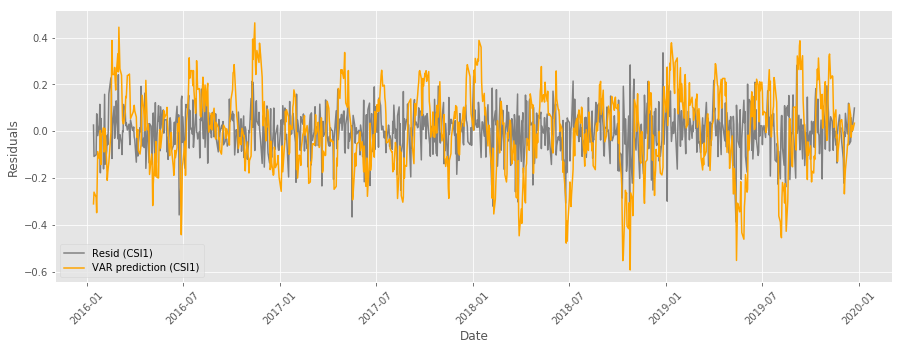

In [54]:
with plt.style.context(("ggplot")):
    y_fitted = res.fittedvalues
    plt.figure(figsize = (15,5))
    plt.plot(res.resid[["csi1"]], label='Resid (CSI1)', color="gray")
    plt.plot(y_fitted["csi1"], label='VAR prediction (CSI1)', color="orange")
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.legend()

#### CSI2

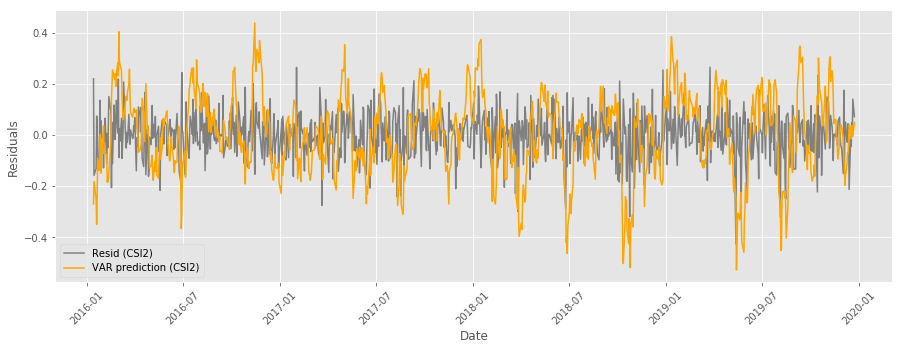

In [55]:
with plt.style.context(("ggplot")):
    y_fitted = res.fittedvalues
    plt.figure(figsize = (15,5))
    plt.plot(res.resid[["csi2"]], label='Resid (CSI2)', color="gray")
    plt.plot(y_fitted["csi2"], label='VAR prediction (CSI2)', color="orange")
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.legend()

### Durbin Watson Test

In [56]:
out = durbin_watson(res.resid)
out.shape

(47,)

In [57]:
for col, val in zip(final_cols, out):
    print(col , " : ", val)

csi1  :  1.9980108677758301
csi2  :  2.1212537775093065
AAPL  :  2.005930163831181
ADM  :  1.9860349721067605
AIZ  :  1.9916509843809793
AJG  :  2.0128939391891145
ALB  :  1.9918021996116806
AMD  :  2.001125871172347
AME  :  2.038012102111208
AMT  :  2.015004892291334
AMZN  :  2.0026517744021897
AVY  :  2.0172446784040754
BIIB  :  1.982240138441298
BKNG  :  1.9711442360580715
BWA  :  2.0411467681066906
CAT  :  1.9982983815691377
CDNS  :  1.9961965351421536
CF  :  1.9857852050855702
CHRW  :  2.008585822975007
CINF  :  2.037605708459076
CL  :  1.967154514152075
CLX  :  1.99533279968515
CME  :  1.9833856791289914
CMI  :  1.9863060664473444
CNC  :  2.0132483948751947
CNP  :  1.990649624957484
COF  :  1.9861123756387
CSCO  :  2.0119926682712563
DGX  :  1.9888728095924806
DISH  :  2.0096173025586275
DLR  :  1.9886396700852706
DPZ  :  1.999452116499095
DVA  :  1.9921738507612692
DXC  :  1.9764804826723732
EBAY  :  2.009694922567498
ECL  :  1.9848825255118214
EMN  :  2.0026083588560915
EMR  : 

### Future Prediction

In [58]:
lag_order = res.k_ar

print("Lag samples to use for future predictions : ", lag_order)
# Input data for forecasting
input_data = X_train_transformed.values[-lag_order:]
#print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
pred

Lag samples to use for future predictions :  1


,csi1_pred,csi2_pred,AAPL_pred,ADM_pred,AIZ_pred,AJG_pred,ALB_pred,AMD_pred,AME_pred,AMT_pred,AMZN_pred,AVY_pred,BIIB_pred,BKNG_pred,BWA_pred,CAT_pred,CDNS_pred,CF_pred,CHRW_pred,CINF_pred,CL_pred,CLX_pred,CME_pred,CMI_pred,CNC_pred,CNP_pred,COF_pred,CSCO_pred,DGX_pred,DISH_pred,DLR_pred,DPZ_pred,DVA_pred,DXC_pred,EBAY_pred,ECL_pred,EMN_pred,EMR_pred,EOG_pred,EQIX_pred,ETN_pred,EW_pred,FCX_pred,FDX_pred,GIS_pred,GOOG_pred,GOOGL_pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24,0.119954,0.087976,0.003633,-0.000007,-0.001472,-0.000064,-0.002194,0.000454,0.000866,0.000184,0.028999,-0.000306,-0.003189,0.030269,0.000408,-0.000218,0.000786,-0.000671,-0.000227,-0.000435,0.000104,-0.000321,-0.001207,0.000026,0.000499,0.000098,-0.001002,0.000338,0.000300,0.000372,0.000177,0.005978,-0.000010,-0.000121,0.000227,0.000360,-0.000501,0.000912,-0.000300,4.189403e-03,-0.000011,0.000423,-0.000061,-0.000250,-0.000324,0.004933,0.002779
2019-12-26,0.104095,0.088927,0.000742,0.000058,0.000116,0.000197,0.000245,0.000137,0.000094,-0.000128,0.000661,-0.000052,-0.001874,-0.008980,-0.000022,0.000457,0.000155,0.000202,-0.000228,0.000160,-0.000155,-0.000369,0.000201,0.000200,-0.000109,0.000004,0.000244,0.000048,0.000032,-0.000247,-0.000156,0.000425,0.000407,0.000318,0.000192,0.000014,0.000230,-0.000025,0.000049,2.887379e-04,0.000232,-0.000014,-0.000009,-0.000529,0.000015,-0.002325,-0.002322
2019-12-27,0.088974,0.086041,0.000229,-0.000027,0.000045,0.000038,-0.000146,0.000111,0.000053,0.000202,0.002931,0.000237,-0.000397,-0.003307,-0.000024,0.000272,0.000067,-0.000028,-0.000149,0.000016,-0.000183,-0.000341,-0.000113,0.000280,0.000042,0.000031,0.000030,0.000015,0.000093,-0.000169,-0.000166,0.000113,-0.000018,0.000089,0.000016,-0.000099,-0.000144,0.000033,0.000025,-7.980925e-07,0.000085,0.000027,0.000017,-0.000011,-0.000090,0.000842,0.000464
2019-12-30,0.077526,0.076855,0.000291,-0.000068,0.000047,0.000038,-0.000233,0.000134,0.000055,0.000128,0.002644,0.000136,-0.000404,-0.001381,-0.000059,0.000239,0.000094,-0.000057,-0.000148,-0.000013,-0.000131,-0.000405,-0.000072,0.000243,0.000053,0.000003,0.000052,0.000004,0.000021,-0.000126,-0.000155,0.000427,-0.000049,0.000159,0.000017,-0.000171,-0.000107,0.000018,0.000090,2.859182e-04,0.000080,0.000079,0.000021,-0.000141,-0.000111,0.001294,0.001185
2019-12-31,0.067680,0.067605,0.000294,-0.000058,0.000056,0.000053,-0.000202,0.000141,0.000062,0.000083,0.002656,0.000125,-0.000282,-0.001334,-0.000058,0.000243,0.000095,-0.000048,-0.000126,-0.000006,-0.000140,-0.000354,-0.000032,0.000223,0.000057,0.000002,0.000040,0.000008,0.000033,-0.000147,-0.000133,0.000340,-0.000052,0.000126,0.000009,-0.000118,-0.000117,0.000017,0.000073,2.397772e-04,0.000087,0.000097,0.000021,-0.000147,-0.000119,0.001134,0.001013


### Inverting Predictions to Get Original Predictions

In [59]:
output = invert_transformation(X_train, pred)

### Checking Model Performance

#### CSI1

In [60]:
#combining predicted and real data set
combine_csi1_y = pd.concat([output['csi1_pred'], X_test['csi1']], axis=1)
combine_csi1_y['accuracy'] = round(combine_csi1_y.apply(lambda row: row.csi1_pred /row.csi1 *100, axis = 1),2)
combine_csi1_y['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1_y['accuracy']],index = combine_csi1_y.index)
combine_csi1_y = combine_csi1_y.round(decimals=2)
combine_csi1_y = combine_csi1_y.reset_index()
combine_csi1_y = combine_csi1_y.sort_values(by='date', ascending=False)
combine_csi1_y

,date,csi1_pred,csi1,accuracy
4,2019-12-31,1.80,1.86,96.88%
3,2019-12-30,1.73,1.79,96.55%
2,2019-12-27,1.65,1.73,95.89%
1,2019-12-26,1.57,1.61,97.00%
0,2019-12-24,1.46,1.44,101.66%


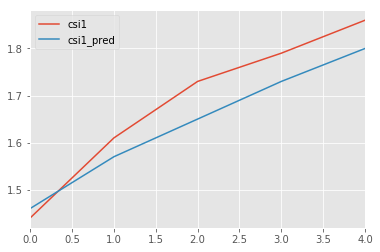

In [61]:
with plt.style.context("ggplot"):
    combine_csi1_y.plot(y=["csi1", "csi1_pred"])

In [62]:
#Forecast bias for CSI1
forecast_errors = [combine_csi1_y['csi1'][i]- combine_csi1_y['csi1_pred'][i] for i in range(len(combine_csi1_y['csi1']))]
bias = sum(forecast_errors) * 1.0/len(combine_csi1_y['csi1'])
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine_csi1_y['csi1'].values, combine_csi1_y['csi1_pred'].values))
print('Mean squared error:', mean_squared_error(combine_csi1_y['csi1'].values, combine_csi1_y['csi1_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi1_y['csi1'].values, combine_csi1_y['csi1_pred'].values)))

Bias: 0.044000
Mean absolute error: 0.052000000000000046
Mean squared error: 0.0031200000000000056
Root mean squared error: 0.05585696017507581


#### CSI2

In [63]:
#combining predicted and real data set
combine_csi2_y = pd.concat([output['csi2_pred'], X_test['csi2']], axis=1)
combine_csi2_y['accuracy'] = round(combine_csi2_y.apply(lambda row: row.csi2_pred /row.csi2 *100, axis = 1),2)
combine_csi2_y['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi2_y['accuracy']],index = combine_csi2_y.index)
combine_csi2_y = combine_csi2_y.round(decimals=2)
combine_csi2_y = combine_csi2_y.reset_index()
combine_csi2_y = combine_csi2_y.sort_values(by='date', ascending=False)
combine_csi2_y

,date,csi2_pred,csi2,accuracy
4,2019-12-31,1.55,1.65,94.42%
3,2019-12-30,1.49,1.56,95.17%
2,2019-12-27,1.41,1.48,95.39%
1,2019-12-26,1.32,1.37,96.37%
0,2019-12-24,1.23,1.22,101.19%


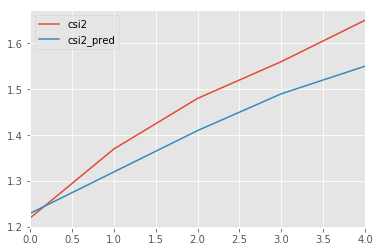

In [64]:
with plt.style.context("ggplot"):
    combine_csi2_y.plot(y=["csi2", "csi2_pred"])

In [65]:
#Forecast bias for CSI2
forecast_errors = [combine_csi2_y['csi2'][i]- combine_csi2_y['csi2_pred'][i] for i in range(len(combine_csi2_y['csi2']))]
bias = sum(forecast_errors) * 1.0/len(combine_csi2_y['csi2'])
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine_csi2_y['csi2'].values, combine_csi2_y['csi2_pred'].values))
print('Mean squared error:', mean_squared_error(combine_csi2_y['csi2'].values, combine_csi2_y['csi2_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi2_y['csi2'].values, combine_csi2_y['csi2_pred'].values)))

Bias: 0.056000
Mean absolute error: 0.06000000000000001
Mean squared error: 0.00448
Root mean squared error: 0.06693280212272604


## Dense Net

### Method 1 : Full Data

In [318]:
def create_dataset(df, future_pred_cnt):

    X = df.drop(columns=["csi1", "csi2"]).values[:-future_pre_cnt]
    Y = df["csi1"].values[future_pre_cnt:]

    print("Dataset Size : ", X.shape, Y.shape)

    X_train, X_test = X[:-future_pre_cnt], X[-future_pre_cnt:]
    Y_train, Y_test = Y[:-future_pre_cnt], Y[-future_pre_cnt:]

    print("Train/Test Sizes : ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [319]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset, future_pre_cnt)

Dataset Size :  (995, 401) (995,)
Train/Test Sizes :  (990, 401) (5, 401) (990,) (5,)


In [320]:
dense_model1 = Sequential([ 
                     #Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(10,  activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(5,  activation='relu'),
                     Dense(1)])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 10)                4020      
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 6         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________
None


In [321]:
dense_model1.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [322]:
history = dense_model1.fit(X_train, Y_train, 
                           batch_size=1, epochs=50, verbose=0, validation_data=(X_test, Y_test), shuffle=False, use_multiprocessing=True);

In [323]:
preds = dense_model1.predict(X_test).flatten()
preds = pd.DataFrame(preds, index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.785809
2019-12-26,1.785809
2019-12-27,1.785809
2019-12-30,1.785809
2019-12-31,1.785809


In [324]:
def combine_results(preds, actual):
    combine_csi1 = pd.concat([preds, actuals], axis=1)
    combine_csi1['accuracy'] = round(combine_csi1.apply(lambda row: row.Preds /row.Actual *100, axis = 1),2)
    combine_csi1['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1['accuracy']],index = combine_csi1.index)
    combine_csi1 = combine_csi1.round(decimals=2)
    combine_csi1 = combine_csi1.reset_index()
    combine_csi1 = combine_csi1.sort_values(by='date', ascending=False)
    return combine_csi1

actuals = pd.DataFrame(Y_test, index=df_subset.index[-future_pre_cnt:], columns=["Actual"])
combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.79,1.86,96.11%
3,2019-12-30,1.79,1.79,99.53%
2,2019-12-27,1.79,1.73,103.48%
1,2019-12-26,1.79,1.61,110.62%
0,2019-12-24,1.79,1.44,124.19%


In [325]:
def calculate_errors(combine_csi1):
    forecast_errors = [combine_csi1['Actual'][i]- combine_csi1['Preds'][i] for i in range(combine_csi1.shape[0])]
    bias = sum(forecast_errors) * 1.0/len(combine_csi1['Actual'])
    print('Bias: %f' % bias)
    print('Mean absolute error:', mean_absolute_error(combine_csi1['Actual'].values, combine_csi1['Preds'].values))
    print('Mean squared error:', mean_squared_error(combine_csi1['Actual'].values, combine_csi1['Preds'].values))
    print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi1['Actual'].values, combine_csi1['Preds'].values)))
    
calculate_errors(combine_csi1)

Bias: -0.104000
Mean absolute error: 0.1319999923706055
Mean squared error: 0.032679992065431145
Root mean squared error: 0.18077608266978004


### Method 2 : CSI1_X Data

In [301]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset_csi_x, future_pre_cnt)

Dataset Size :  (995, 130) (995,)
Train/Test Sizes :  (990, 130) (5, 130) (990,) (5,)


In [302]:
dense_model1 = Sequential([ 
                     #Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(10,  activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(10,  activation='relu'),
                     Dense(1)])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 10)                1310      
_________________________________________________________________
dense_62 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________
None


In [303]:
dense_model1.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [304]:
history = dense_model1.fit(X_train, Y_train, 
                           batch_size=1, epochs=50, verbose=0, validation_data=(X_test, Y_test), shuffle=False, use_multiprocessing=True);

In [305]:
preds = dense_model1.predict(X_test).flatten()
preds = pd.DataFrame(preds, index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.676237
2019-12-26,1.676237
2019-12-27,1.676237
2019-12-30,1.676237
2019-12-31,1.676237


In [306]:
actuals = pd.DataFrame(Y_test, index=df_subset.index[-future_pre_cnt:], columns=["Actual"])
combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.68,1.86,90.21%
3,2019-12-30,1.68,1.79,93.43%
2,2019-12-27,1.68,1.73,97.13%
1,2019-12-26,1.68,1.61,103.83%
0,2019-12-24,1.68,1.44,116.57%


In [307]:
calculate_errors(combine_csi1)

Bias: 0.006000
Mean absolute error: 0.13000001049041748
Mean squared error: 0.02190000062942781
Root mean squared error: 0.1479864879961269


### Method 3 : CSI_Y Data

In [308]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset_csi_y, future_pre_cnt)

Dataset Size :  (995, 107) (995,)
Train/Test Sizes :  (990, 107) (5, 107) (990,) (5,)


In [309]:
dense_model1 = Sequential([ 
                     #Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(10,  activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(10,  activation='relu'),
                     Dense(1)])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 10)                1080      
_________________________________________________________________
dense_65 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None


In [310]:
dense_model1.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [311]:
history = dense_model1.fit(X_train, Y_train, 
                           batch_size=1, epochs=50, verbose=0, validation_data=(X_test, Y_test), shuffle=False, use_multiprocessing=True);

In [312]:
preds = dense_model1.predict(X_test).flatten()
preds = pd.DataFrame(preds, index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.608572
2019-12-26,1.608572
2019-12-27,1.608572
2019-12-30,1.608572
2019-12-31,1.608572


In [313]:
actuals = pd.DataFrame(Y_test, index=df_subset.index[-future_pre_cnt:], columns=["Actual"])
combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.61,1.86,86.57%
3,2019-12-30,1.61,1.79,89.65%
2,2019-12-27,1.61,1.73,93.21%
1,2019-12-26,1.61,1.61,99.64%
0,2019-12-24,1.61,1.44,111.87%


In [314]:
calculate_errors(combine_csi1)

Bias: 0.076000
Mean absolute error: 0.14399999713897707
Mean squared error: 0.02763999782562278
Root mean squared error: 0.16625281298559366


## XGBoost

### Method 1 : Full Data

In [199]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset, future_pre_cnt)

Dataset Size :  (995, 401) (995,)
Train/Test Sizes :  (990, 401) (5, 401) (990,) (5,)


In [184]:
xgb_reg = xgb.XGBRFRegressor(n_estimators=150, max_depth=5,  objective='reg:squarederror', verbosity=1)

In [185]:
xgb_reg.fit(X_train, Y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [186]:
preds = xgb_reg.predict(X_test), 
preds = pd.DataFrame(preds[0], index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.499771
2019-12-26,1.476315
2019-12-27,1.487314
2019-12-30,1.352597
2019-12-31,1.438982


In [191]:
#combining predicted and real data set
actuals = pd.DataFrame(Y_test, index=df_subset.index[-future_pre_cnt:], columns=["Actual"])

combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.44,1.86,77.44%
3,2019-12-30,1.35,1.79,75.39%
2,2019-12-27,1.49,1.73,86.18%
1,2019-12-26,1.48,1.61,91.45%
0,2019-12-24,1.50,1.44,104.30%


In [196]:
calculate_errors(combine_csi1)

Bias: 0.234000
Mean absolute error: 0.2579999780654908
Mean squared error: 0.08961998428344815
Root mean squared error: 0.299365970483367


### Method 2 : CSI1_X Data

In [200]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset_csi_x, future_pre_cnt)

Dataset Size :  (995, 130) (995,)
Train/Test Sizes :  (990, 130) (5, 130) (990,) (5,)


In [201]:
xgb_reg = xgb.XGBRFRegressor(n_estimators=150, max_depth=5,  objective='reg:squarederror', verbosity=1)

In [202]:
xgb_reg.fit(X_train, Y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [203]:
preds = xgb_reg.predict(X_test), 
preds = pd.DataFrame(preds[0], index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.632525
2019-12-26,1.741335
2019-12-27,1.620016
2019-12-30,1.701115
2019-12-31,1.665338


In [204]:
combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.67,1.86,89.63%
3,2019-12-30,1.70,1.79,94.81%
2,2019-12-27,1.62,1.73,93.87%
1,2019-12-26,1.74,1.61,107.86%
0,2019-12-24,1.63,1.44,113.53%


In [205]:
calculate_errors(combine_csi1)

Bias: 0.014000
Mean absolute error: 0.1419999990463257
Mean squared error: 0.021860001468659303
Root mean squared error: 0.14785128159288746


### Method 3 : CSI1_Y Data

In [263]:
future_pre_cnt = 5

X_train, X_test, Y_train, Y_test = create_dataset(df_subset_csi_y, future_pre_cnt)

Dataset Size :  (995, 107) (995,)
Train/Test Sizes :  (990, 107) (5, 107) (990,) (5,)


In [264]:
xgb_reg = xgb.XGBRFRegressor(n_estimators=150, max_depth=5,  objective='reg:squarederror', verbosity=1)

In [265]:
xgb_reg.fit(X_train, Y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [267]:
preds = xgb_reg.predict(X_test), 
preds = pd.DataFrame(preds[0], index=df_subset.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,1.339128
2019-12-26,1.445290
2019-12-27,1.397194
2019-12-30,1.168794
2019-12-31,1.229756


In [268]:
combine_csi1 = combine_results(preds, actuals)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,1.23,1.86,66.18%
3,2019-12-30,1.17,1.79,65.14%
2,2019-12-27,1.40,1.73,80.96%
1,2019-12-26,1.45,1.61,89.53%
0,2019-12-24,1.34,1.44,93.13%


In [269]:
calculate_errors(combine_csi1)

Bias: 0.368000
Mean absolute error: 0.3679999933242798
Mean squared error: 0.1851600045967115
Root mean squared error: 0.43030222471736246
